In [922]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model, Parameter,Parameters, report_fit

from scipy.optimize import curve_fit
from scipy import stats as st
import scipy.signal as sps
from scipy.signal import convolve2d
from scipy.special import erf
from scipy.special import factorial
from scipy.special import gamma
import scipy.ndimage as nd

from glob import glob
import natsort
import imageio
import skimage

import os 

import sys

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Preface

This code is used to, when given a real plasma image captured at 90 degrees with respect to a target and laser direction, simulate the image using a Skewed Psuedo Voigt Profile and some sneaky methodology. 

Please note that this code can be simply converted to a .py file with some minor changes (as the majority of the code here is functionalised) and loaded as a package and applied to many plasma images adhoc, or you can use the notebook as is. 

# 0. Specify the paths and load the images
First we load the dataframe which contains the details for each plasma configurations'
   - Energy
   - Relative focus
   - Image start index number
   - Image end index end number
    
See [notebook] for more. image_selector is a function which generates the indices that label each image to be pulled from the data folder. So for example, one can pick 
   - E = 50mJ
   - z = 10080
   
This will return a list i.e. [0,1,2,3,4] which will allow following functions to load and analyse all images at 50mJ and z = 10080. This means **the paths must be sorted numerically**, which is done below with natsort. Natsort is required because the integer number of the image appears at the end of the images.


In [706]:
paths = glob('/home/kevinm/Spec_Proj_Dir/Speclab/Experiment One - Pinhole Imaging/12_2020_pinhole_images/15_12_2020c/*.png')
paths_sorted = natsort.natsorted(paths, key=lambda y: y.lower())

# 1. Define a function to select images at certain focii and energies

In [1162]:
W_imagekey = pd.read_csv('W_ImageKey.csv')
W_imagekey


def image_selector(df,energy,focus):
    #Taking a slice of df, loc may be used instead
    start = df[(df['Energy']==energy)
                 & (df['Lens Position']==focus)]['Image Index Start No.'].values
    end = df[(df['Energy']==energy)
               & (df['Lens Position']==focus)]['Image Index End No.'].values
    
    #Exceptions are images in the sequence that did not capture correctly 
    # i.e. off the target, unsmooth target 
    exceptions = list(df[(df['Energy']==energy)
                       & (df['Lens Position']==focus)]['File Exceptions'])
    
    image_range = []
    for i,start_pts in enumerate(start):
        im_range = np.arange(start_pts,end[i]+1)
        image_range += [k for k in im_range]
    
    #remove exceptions
    image_range_adj = [k for k in image_range if k not in exceptions]
    return image_range_adj


In [708]:
W_imagekey[W_imagekey['Energy'] == 50]

W_imagekey[(W_imagekey['Energy']==50)
          &(W_imagekey['Lens Position']==10240)]['Image Index Start No.'].values

array([411])

# 2. Define functions that will be used to fit the plasma on each _normal_ axis 

## Fitting Functions

### Gaussian
The spatial distribution of the plasma parallel to the target can be described by a Gaussian function:

\begin{equation*}
G(x;\sigma,\mu) = \frac{A}{\sigma\sqrt{2\pi}}\exp\Bigg(-\frac{(x-\mu)^{2}}{2\sigma^{2}} \Bigg)
\end{equation*}

In the fitting, $G(x)$ is normalised, scaled to the height of the camera intensity H and also shifted above 0 with an Offset O. During fitting, the effective function is

\begin{equation*}
G_fit(x) = O + H\times G_{norm}(x)
\end{equation*}

### Lorentzian
The spatial distribution of the plasma parallel to the target can also be described by a Lorentzian function:

\begin{equation*}
L(x;x_{0},\gamma) = \frac{1}{\pi\gamma}\Bigg[\frac{\gamma^{2}}{(x-x_{0})^{2} + \gamma^{2}} \Bigg]
\end{equation*}

Normalisation, offsetting and height scaling are repeated as described above.

### Pseudo Voigt Profile 
In reality, the spatial plasma distribution parallel to the target may be either Gaussian, Lorentzian or a convultion of the two. This is best treated by itting the distribution with a Pseudo Voigt profile with scaling parameter $\eta$: when $\eta$ is 0, the function is entirely Lorentzian; when $\eta$ is 1 the function is entirely Gaussian and any values in between is a linear combination of the two distributions.

\begin{equation*}
V_{p}(x,f) = \eta\:G(x)\; + \;(1-\eta) L(x) \;\;\; with \;\;\; 0 < \eta < 1
\end{equation*}

Normalisation, offsetting and height scaling are repeated as described above. 


### Exponentially Modified Gaussian
The spatial distribution of the plasma perpendicular to the target **can be** described with an exponentiall modified Gaussian. 

\begin{equation*}
f(x;\mu,\sigma,\lambda) = \frac{\lambda}{2}\exp\big(2\mu + \lambda\sigma^{2} - 2x\big)erfc\Bigg(\frac{\mu + \lambda\sigma^{2} -x}{\sigma\sqrt{2}}\Bigg)
\end{equation*}

where

\begin{equation*}
erfc(x) = 1 - erf(x) = \frac{2}{\pi}\int_{x}^{\inf}e^{-t^{2}}dt
\end{equation*}

### Exponentially Modified Pseudo-Voigt Profile
The spatial distribution of the plasma perpendicular to the target **is best described** with an exponentiall modified Pseudo-Voigt Profile. 

\begin{equation*}
f(x;\mu,\sigma,\lambda) = \frac{\lambda}{2}\exp\big(2\mu + \lambda\sigma^{2} - 2x\big)erfc\Bigg(\frac{\mu + \lambda\sigma^{2} -x}{\sigma\sqrt{2}}\Bigg)
\end{equation*}

where

\begin{equation*}
erfc(x) = 1 - erf(x) = \frac{2}{\pi}\int_{x}^{\inf}e^{-t^{2}}dt
\end{equation*}
t

In [1164]:
def Gauss(x,offset,height,sigma,mu):
    xp = np.max(x) - x
    fn = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-0.5*(xp-mu)**2)/(sigma**2))
    fn_normed = fn/1                                        
    return offset + (height-offset)*fn_normed


def Lorentz(x,offset,height,gamma,mu):
    xp =np.max(x) - x
    fn = ((gamma**2)/((xp-mu)**2 + gamma**2))*1/(np.pi*gamma)
    fn_normed = fn/1
    return offset + (height-offset)*fn_normed


def Pseudo_Voigt(x,offset,fraction,G_height,L_height,gamma,mu,sigma):
    xp = np.max(x) - x
    G = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-0.5*(xp-mu)**2)/(sigma**2))
    G_normed = G/1
                                             
    L = (1*((gamma**2)/((xp-mu)**2 + gamma**2))*1/(np.pi*gamma))
    L_normed = L/max(L)
    return offset + (L_height - offset)*(1-fraction)*L + (G_height - offset)*(fraction)*G


def Modded_Gauss(x,offset,height,sigma,mu,lambd):
    xp = np.max(x) - x
    erfc = 1 - erf((mu + lambd*sigma**2 - xp)/(sigma*np.sqrt(2)))
    gauss = np.exp((lambd/2)*(-2*mu + lambd*sigma**2 - 2*xp))*lambd/2
    fn = height*(erfc*gauss)
    fn_normed = fn/1
    
    return offset + (height-offset)*fn_normed


def Skewed_Gauss(x,offset,height,sigma,mu,alpha):
    xp = np.max(x) - x
    gfn = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-0.5*(xp-mu)**2)/(sigma**2))
    skewed_erfn = .5*(1+erf((alpha*(xp-mu)/sigma)/np.sqrt(2)))
    
    fn = 2*gfn*skewed_erfn
    fn_normed = fn/1                                       
    return (height)*fn_normed

def Skewed_Voigt(x,offset,height,sigma,mu,lambd,alpha):
    xp = np.max(x) - x
    erfc = 1 - erf((mu + lambd*sigma**2 - xp)/(sigma*np.sqrt(2)))
    gauss = np.exp((lambd/2)*(-2*mu + lambd*sigma**2 - 2*xp))*lambd/2
    vfn = erfc*gauss
    
    skewed_erfn = .5*(1+erf((alpha*(xp-mu)/sigma)/np.sqrt(2)))
    
    fn = 2*vfn*skewed_erfn
    
    fn_normed = fn/1                                        
    return offset + (height-offset)*fn_normed


# 3. Define a function to find the exp. Full Width Half Max of a distribution

## Exper. FWHM function
This function allows one to find the FWHM of the experimental distributions without fitting.

The function passes a distribution, i.e. the summed or averaged plasma along one axis, and then the half max is found of the distribution. Then, the position on the x axis at which this occurs before and after the peak of the distributions are found i.e. the args of the half max. These arguments are returned from the function. **No interpolation is performed here**, but this may be done if a perfectly horizontal FWHM is required. This function is just used as a crude estimate.

In [711]:
def exper_FWHM(distrib):
    try:
        #Zero distribution so minimum point lies at 0
        zeroed_distrib = distrib - min(distrib)
    
    #Find HM
        hm = max(zeroed_distrib)/2
    
        #Find two 'x' points i.e. the Intensity args that correspond to FWHM
        pre_peak =  [i for i,val in enumerate(zeroed_distrib) if i < np.argmax(zeroed_distrib)]
        post_peak = [i for i,val in enumerate(zeroed_distrib) if i > np.argmax(zeroed_distrib)]

        pre_peak_fwhm = min(zeroed_distrib[pre_peak ], key=lambda y:abs(y - hm))
        post_peak_fwhm = min(zeroed_distrib[post_peak], key=lambda y:abs(y - hm))

        pre_peak_fwhm_arg  = np.where(zeroed_distrib == pre_peak_fwhm)[0][0]
        post_peak_fwhm_arg = np.where(zeroed_distrib == post_peak_fwhm)[0][0]

    except ValueError:
        pre_peak_fwhm_arg = 50
        post_peak_fwhm_arg = 100
    return pre_peak_fwhm_arg,post_peak_fwhm_arg
#fwhm*pixel size / magnification 

# 4. - Define some General Plasma Functions

## 1. Image Centers function (image_centers_fn)
#### One liner - Finds the centers of the averaged distributions on each axis and the center of mass of the plasma


\
This function finds the center of the plasma based on __the average distributions of the plasma along each axis__ first and then returns the __Center of Mass of the plasma__.




## 2. Image Summing function (image_summing_fn)
#### One liner - Sums images about their center of masses

\
This function is used to sum many images. In this experiment, multiple plasma images are saved per given energy and focus. It is useful to sum these plasmas to reveal some general properties about the plasma i.e. FWHM etc. This summing function takes in multiple images, ideally from the same experimental configurations. It then finds the CoM of each image. The images are then cropped about their COM using the "plasma window" argument to form matrices of the same dim. These can then be summed / average.



## 3. fwhm function (fwhm_fn)
#### One liner - finds the fwhm of a plasma image

\
This function operates in a similar manner to the fwhm function above and in fact uses it. This function however takes a plasma image, and returns the dist. of the fwhm instead of the args. This function allows for strips of the plasma to be looked at about the center. i.e. look at a strip of the plasma 2 pixels about the center along a given axis.



## 4. Plasma Intensity (plasma_intensity_fn)
#### One liner - Finds the intensity of the plasma over a given window centered about the CoM

The plasma intensity function is passed a plasma image, and returns a list which contains the intensity of the plasma relative to its minimum value or mean value (this has to be changed) across a range of "strips" of the plasma. The reason for only looking at sections of plasma is that you may only want to view the relative plasma intensity about the center of mass of the plasma rather than including cooler parts of the  plasma further from the center. The relative intensity is taken because the background increases at a different rate to the peak as the window 



## 5. Plasma Slicing Function (plasma_slicing_fn)
#### One liner - Slices the plasma about its center of mass along each normal axis

\
This function takes evenly spaced slices of the plasma about the center of mass along each axis. This can allow one to look at the evolution of the plasma intensity as a function of distance from the com


In [ ]:
def image_centers_fn(image_matrix):
    #METHOD ONE:

    image_matrix += - np.min(image_matrix)
    
    axis1_mean = np.mean(image_matrix, axis = 1)[:1700]
    axis0_mean = np.mean(image_matrix, axis = 0)

    axis1_marg = np.argmax(axis1_mean)
    axis0_marg = np.argmax(axis0_mean)

    #axis1_marg is the center of the "x" axis
    #axis0_marg is the center of the "y" axis

    x0 = []
    x1 = []
    axis0_max = []
    axis1_max = []   
    
    min_rng = min([len(axis1_mean),len(axis0_mean)])
    loop_range = int(min_rng/2)
    #print(loop_range)
    #print([len(axis1_mean),len(axis0_mean)])
    
    try:
        for i in range(-loop_range+1,loop_range-1):
            
            #The new center
            new_axis0_center = axis0_marg + i
            new_axis1_center = axis1_marg + i

            x0.append(new_axis0_center)
            #axis0_max is Skewed Gaussian
            axis0_max.append(np.mean(image_matrix[:,new_axis0_center]))

            x1.append(new_axis1_center)
            #axis1_max is Gaussian
            axis1_max.append(np.mean(image_matrix[new_axis1_center]))

        fwhm0 = exper_FWHM(axis0_max)
        
        axis0_max += - np.min(axis0_max)
        axis1_max += - np.min(axis1_max)
        
        plt.plot(axis0_max)
        
        skgopt,skgcov = curve_fit(Skewed_Gauss,x0,axis0_max, p0 = [min(axis0_max),max(axis0_max)
                                                                  ,(fwhm0[1]-fwhm0[0])/2,np.argmax(axis0_max)
                                                                  ,3],maxfev = 100000)

        fwhm1 = exper_FWHM(axis1_max)
        gopt,gcov = curve_fit(Gauss,x1,axis1_max, p0 = [min(axis1_max),max(axis1_max)
                                                       ,(fwhm1[1]-fwhm1[0])/2,np.argmax(axis1_max)]
                                                       ,maxfev = 100000)

        axis0_center = x0[np.argmax(Skewed_Gauss(x0,*skgopt))]
        axis1_center = x1[np.argmax(Gauss(x1,*gopt))]


    except ValueError:
        axis0_center = axis0_marg
        axis1_center = axis1_marg
        print('Value Error')

    if np.sqrt((axis0_center - axis0_marg)**2 + (axis1_center - axis1_marg)**2) >= 100:
        axis1_center = axis1_marg
        axis0_center = axis0_marg
        
    return axis1_center,axis0_center, axis1_marg,axis0_marg
    


def image_summing_fn(image_matrices, plasma_window):
    for j,image_matrix in enumerate(image_matrices):
        image_center = image_centers_fn(image_matrix)
        #First initiate empty matrix to be summed to.
        if j == 0:
            im_base = np.zeros((2*plasma_window,2*plasma_window))
        #Swap these necessary for plotting remember!
        axis1center = image_center[1] 
        axis0center = image_center[0]
        pw = plasma_window
        image_rescaled = image_matrix[axis0center-pw : axis0center+pw
                                    :,axis1center-pw : axis1center+pw]
        im_base += image_rescaled
    return im_base

def fwhm_fn(image_matrix, slice_start, slice_end, slice_spacing):
    fwhm_list = []
    image_center = image_centers_percentile_fn(image_matrix,[99.9])
    axis0center = image_center[0]
    axis1center = image_center[1]
    
    for i in np.arange(slice_start,slice_end,slice_spacing):
        
        """
        For the axis 0 which sums the rows (the exp modded Gaussian)
            - image[axis_center - ...]
            - np.sum(..., axis  = 0 )


        For the axis 1 which sums the columns direction (the Pseudo Voigt)
            - image[:, axis_center - ...]
            - np.sum(..., axis  = 1 )
        """
        sliced_im_axis1 = image_matrix[:,axis1center - i:axis1center + i]
        mean_axis1_distrib = np.sum(sliced_im_axis1, axis = 1)
        
        fwhm = exper_FWHM(mean_axis1_distrib)
        fwhm_list.append(fwhm[1]-fwhm[0])

    return fwhm_list


def summed_images_plotter(paths,df_imagekey,energy,focus,plasma_window):
    
    paths_sorted = natsort.natsorted(paths, key=lambda y: y.lower())
    path_indices = image_selector(df_imagekey,energy,focus)
    
    images = []
    for path_index in path_indices:
        path = paths_sorted[path_index]
        image = imageio.imread(path)
        images.append(image)

    imsum = image_summing_fn(images, plasma_window)
    plt.imshow(imsum)
    
    
def plasma_intensity(image_matrix, slice_start, slice_end, slice_spacing):
    intensity_list = []
    image_center = image_centers_percentile_fn(image_matrix,[99.9])
    axis0center = image_center[0]
    axis1center = image_center[1]
    
    #print(com_col_cent,com_row_cent)
    for i in np.arange(slice_start,slice_end,slice_spacing):

        """
        For the axis 0 which sums the rows (the exp modded Gaussian)
            - image[axis_center - ...]
            - np.sum(..., axis  = 0 )


        For the axis 1 which sums the columns direction (the Pseudo Voigt)
            - image[:, axis_center - ...]
            - np.sum(..., axis  = 1 )
        """
        
        sliced_im_axis0 = image_matrix[axis0center - i:axis0center + i]
        
        
        sliced_im_axis1 = image_matrix[:,axis1center - i:axis1center + i]
        
        axis0_sum = np.sum(sliced_im_axis0, axis = 0)
        axis1_sum = np.sum(sliced_im_axis0, axis = 1)

        axis0_sum_avg = np.mean(axis0_sum)
        axis1_sum_avg = np.mean(axis1_sum)

        axis0_amplitude = max(axis0_sum) - axis0_sum_avg
        axis1_amplitude = max(axis1_sum) - axis1_sum_avg

        intensity_list.append([axis0_amplitude,axis1_amplitude])
        
    return intensity_list


def plasma_slicing_fn(image_matrix, slice_start, slice_end, slice_spacing):
    image_center = image_centers_percentile_fn(image_matrix,[99.9])
    axis0center = image_center[0]
    axis1center = image_center[1]
    
    sliced_im_list = []
    for i in np.arange(slice_start,slice_end,slice_spacing):

        """
        For the axis 0 which sums the rows (the exp modded Gaussian)
            - image[axis_center - ...]
            - np.sum(..., axis  = 0 )


        For the axis 1 which sums the columns direction (the Pseudo Voigt)
            - image[:, axis_center - ...]
            - np.sum(..., axis  = 1 )
        """
        
        sliced_im_axis0 = image_matrix[axis0center - i:axis0center + i+1]
        sliced_im_axis1 = image_matrix[:,axis1center - i:axis1center + i+1]
        
        sliced_im_list.append([sliced_im_axis0,sliced_im_axis1])
        
    
    return sliced_im_list
        
def square_image_cropper(image,crop_percentage):
    image_center = image_centers_percentile_fn(image,[99.9])
    axis0_maxpoint = image_center[0]
    axis1_maxpoint = image_center[1]    
    
    mean0 = []
    mean1 = []
    if axis0_maxpoint < image.shape[0]/2:
        axis0_closest_edge = 3
    else:
        axis0_closest_edge = image.shape[0]-3


    if axis1_maxpoint < image.shape[1]/2:
        axis1_closest_edge = 3
    else:
        axis1_closest_edge = image.shape[1]-3


    square0 = axis0_closest_edge-axis0_maxpoint 
    square1 = axis1_closest_edge-axis1_maxpoint

    if square0 < square1:
        sq_side = square0
    else:
        sq_side = square1
    sq_side+=-int(sq_side*crop_percentage)
    sq_side+=-int(sq_side*crop_percentage)
    cropped_image = image[axis0_maxpoint - sq_side-1:axis0_maxpoint + sq_side+2:
                         ,axis1_maxpoint - sq_side-1:axis1_maxpoint + sq_side+2]


    return cropped_image


## image dead pixel remover (image_zero_pixel_remover)

#### One liner - Removes singular dead pixels in an image using 2D convolutions
\
This function uses a 2d convolution to remove dead pixels. See the code below. It doesn't work especially well for groups of dead pixels, but these don't occur too frequently. One can also bin the image and find that the first max peak likely corresponds to the general background. This can lead to negative values in the image, which can have a detrimental impact on fitting functions later on. 


## Image Centering Function via Percentiles (image_centers_percentile_fn)

#### One liner - Finds the centers of the images using percentiles
\
This function uses a percentile methodology to find the center, common in images with a generally "bright region". The image is cropped about the brightest pixel generously, which occurs near the center of the plasma plume in images with good transmission. 

A percentile is then set. It is found empirically that for Tungsten, Platinum and Zinc images with reasonable transmission, 99.9 is a good percentile value. np.percentile is used which when applied to the image matrix returns the value of the 99.9th percentile. We then create a mask from this value i.e. a boolean 2D array at which values greater than this value. 

Then, np.nonzero is used to find the arguments at which the values above the 99th percentile occurs. Then the average of these x and y values are taken. The integer value of average x and y is treated as the center x and y of the plasma respectively. If the new center is more than 20 pixels away from the brightest pixel, then we just treat the brightest pixel as the center. 

In [1180]:

#include ref 
def image_zero_pixel_remover(image_matrix):

    # Define kernel for convolution                                         
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]]) 

    # Perform 2D convolution with input data and kernel 
    conv_out = convolve2d(image_matrix, kernel, boundary='wrap', mode='same')/kernel.sum()

    # Initialize output array as a copy of input array
    image_out = image_matrix.copy()

    mask = image_matrix==0
    image_out[mask] = conv_out[mask]
    return image_out

def image_centers_percentile_fn(img_matrix,pctl_list):
    nonzx = []
    nonzy = []
    
    image_zeros_removed = image_zero_pixel_remover(img_matrix)
    image_back_removed = image_zeros_removed - np.min(image_zeros_removed)
    
    argmax0 = np.argmax(np.mean(image_back_removed,axis = 0))
    argmax1 = np.argmax(np.mean(image_back_removed,axis = 1)[:1700])
    
    bound = 300
    
    pre_squared_image = image_back_removed[argmax1 - bound:argmax1+bound+1:,argmax0-bound:argmax0+bound+1]
    
    for pctl in pctl_list:
        v = np.percentile(pre_squared_image,pctl)
        mask = pre_squared_image >= v
        masked_image = np.multiply(pre_squared_image,mask)
        nonz = np.nonzero(masked_image)
        nonzx.append(argmax1-bound+np.mean(nonz[0]))
        nonzy.append(argmax0-bound+np.mean(nonz[1]))
        
        xc = int(nonzx[0])
        yc = int(nonzy[0])
        
        if abs(argmax1 - int(nonzx[0])) > 20 or abs(argmax0 - int(nonzy[0])) > 20:
            print([abs(argmax0 - int(nonzx[0]))])
            xc = argmax1
            yc = argmax0

        
    return xc,yc,nonz,masked_image
    
    

# 5. Rotate the image and find cross sections

## Image  rotation function(image_rotator_strip)

- image - the image to find the parameters of
- degree step - the step of degrees between 0 and 360 degrees at which the image is roated by
- strip width - **How strips about the center of the plasma are averaged**
- defined range  - A boolean. If True, pre_angle_range is used
- pre_angle_range - A set of predefined angles at which cross sections will be calculated. Can be non integer
- crop_percentage - The amount at which to crop the image by in square_image_cropper
- center - Depreciated
- bool_cropper - A boolean. If True, crop_poercentage is used

In [1094]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt

def image_rotator_strip(image,degree_step,strip_width, defined_range
                       ,pre_angle_range,crop_percentage,center
                       ,bool_cropper):
    
    
    #corner_for_scaling = image[2076-20:2076,3088-20:3088]
    
    image_flattened = image #- np.min(corner_for_scaling)
    #print('Corner Minimum is', np.min(corner_for_scaling))
    
    if bool_cropper is True:
        squim = square_image_cropper(image_flattened,crop_percentage)
    else:
        squim = image_flattened
    #squimcent = imcent
    print('Square minimum' ,np.min(squim))
    
    squim += -np.min(squim)
    
    center = int(len(squim)/2)
    deg_start = 0
    deg_step = degree_step
    deg_stop = 361
    angle_range = np.arange(deg_start,deg_stop,deg_step)
    
    if defined_range is True:
        angle_range = pre_angle_range
    
    heights = np.zeros(len(angle_range))
    sigmas = np.zeros(len(angle_range))
    mus = np.zeros(len(angle_range))
    fractions = np.zeros(len(angle_range)) 
    alphas = np.zeros(len(angle_range))    
    rte = 0
    fc = 0
    kc = 0
    
    
    """
    The fraction value appears to take a roughly quadratic form period about 180 degrees.
    To help the function converge on a meaningful minimum, we will offer a simple "guess function"
    which is simply two guess quadratics, one offset by 0 and one offset by 180 degrees. These functions
    simply say 
    - At 0 degrees, I guess the etra fraction is 0.5 --> half lorentzian and half gaussian
    - At 90 degrees, I guess the eta fraction is 0 --> entirely gaussian
    - At 180 degrees, I guess the eta fraction is 0.5 --> half lorentzian and half gaussian.
    
    This is repeated for 180,270 and 360 degrees with the same guesses. From these 3 points, the coefficient
    values are estimated to form a quadratic shape. This is just to stop the eta values getting stuck at 0 or 1 
    or fluctuating randomly. Work has shown the differenece between a free eta and a fixed eta of 0.3-0.6 is 
    minimal, so this should not be a hugely controversial method of guiding the value of eta. 
    """
  
    x0_180 = np.arange(0,181,1)
    x180_360 = np.arange(181,361,1)

    def quadratic_shifted(x,a,b,c,xshift):
        xp = x - xshift
        return a*xp**2 + b*xp + c
    
    quad_guess0_180 = quadratic_shifted(x0_180,6e-5,-.01,.5,10)
    quad_guess180_360 = quadratic_shifted(x180_360,6e-5,-.01,.5,180)
    
    quad_guess = np.concatenate((quad_guess0_180,quad_guess180_360),axis = 0)
    #print(len(quad_guess))
    
    cx_amps = []
    fx_amps = []
    filenames = []
    for i,val in enumerate(angle_range):
        if i %100 == 0:
            print(i)
        img_rotated = ndimage.rotate(squim, val+1, reshape=False, cval = np.mean(image))
        imrot_strip = img_rotated[center-strip_width:center+strip_width+1]
        mean_graph = np.divide(np.sum(imrot_strip, axis = 0),2*strip_width+1)

        fwhm = exper_FWHM(mean_graph)
        x = np.arange(len(mean_graph))
        y = mean_graph - np.min(mean_graph)
        fwhm_val = x[fwhm[1]]-x[fwhm[0]]
        
        nms = ['heights','sigmas','mus','fractions','alphas']
        
        
        skv_bounds = ((1                                 ,1          ,int(len(y)/3)   ,0.0,-9.5)
                     ,(1.2*np.sqrt(2)*fwhm_val*np.max(y) ,4*fwhm_val ,len(y)          ,0.9, 9.5))
        
        if i == 0:
            new_guesses = [np.sqrt(2)*max(y)*fwhm_val/2
                          ,(abs(x[fwhm[1]]-x[fwhm[0]])/2)
                          ,x[np.argmax(y)],0.5,-4]
            
        else:
            new_guesses = [popt[0],popt[1],popt[2],popt[3],linear_alpha(val,slope,intercept)]
        try:

            model = Model(Skewed_Pseudo_Voigt_fit)
            
            
            model_params = Parameters()
            model_params.add('height',value = new_guesses[0],max = skv_bounds[1][0], min = skv_bounds[0][0])
            model_params.add('sigma',value = new_guesses[1],max = skv_bounds[1][1], min = skv_bounds[0][1])
            model_params.add('mu',value = new_guesses[2],max = skv_bounds[1][2], min = skv_bounds[0][2])
            model_params.add('fraction',value = new_guesses[3],max = skv_bounds[1][3], min = skv_bounds[0][3])
            model_params.add('alpha',value = new_guesses[4],max = skv_bounds[1][4], min = skv_bounds[0][4])
            
            result  = model.fit(y,model_params,xp = x,max_nfev = 12000)

            param_fit_values = result.values
            
                    
            heights[i] = param_fit_values['height']
            sigmas[i] = param_fit_values['sigma']
            mus[i] = param_fit_values['mu'] - center
            fractions[i] = param_fit_values['fraction']
            alphas[i] = param_fit_values['alpha']
            
            popt = list(param_fit_values.values())
            fc +=1
        
        
            cx_amps.append(np.max(y))
            fx_amps.append(np.max(Skewed_Pseudo_Voigt_fit(x,*popt)))
            

            if i == 0:
                print(np.max(y))
                
                
                x1,x2 = (0,180)
                y1,y2 = (popt[4],-popt[4])
                
                slope = (y2-y1)/(x2-x1)
                intercept = y1
                xf = np.arange(0,180,1)

            if val >= 180 and kc == 0:
                x1,x2 = (180,360)
                y1,y2 = (popt[4],-popt[4])
                
                slope = (y2-y1)/(x2-x1)
                intercept = popt[4] - slope*180
                kc += 1
                
                
        except RuntimeError:
            pass
            rte +=1

            
    print('Number of fits', fc)
    print('Run time Errors = %i'%rte)
    return heights,sigmas,mus,fractions,alphas

In [1133]:
def Skewed_Pseudo_Voigt_fit(xp,height,sigma,mu,fraction,alpha):
    
    sigma_g = sigma/np.sqrt(2*np.log(2))
    G = (1/(sigma_g*np.sqrt(2*np.pi)))*np.exp((-0.5*(xp-mu)**2)/(sigma_g**2))

    L = (sigma/((xp-mu)**2 + sigma**2))*1/(np.pi)
    L_normed = L/1
    
    P_Voigt = 1*fraction*L + (1-fraction)*G
    erfc = 1 + erf(alpha*(xp-mu)/(sigma*np.sqrt(2)))
    
    fn = P_Voigt*erfc
    fn_normed = fn/1
    return height*fn_normed
    

In [1134]:
def Skewed_Pseudo_Voigt_synthetic_plasma(r,theta,height,sigma,mu,fraction,alpha):
    x = np.multiply(r,np.cos(theta))
    y = np.multiply(r,np.sin(theta))

    r = np.multiply(r,1)
    
    #fraction = fraction_val
    
    ones = np.ones(theta.shape)*1
    #ones[cent::,:cent] *= 1
    #ones[:cent:,] *= 1
    
    sigma_g = np.divide(sigma,np.sqrt(np.multiply(2,np.log(2))))
    
    xp = ones*r
    gfn = np.multiply(np.divide(1,(np.multiply(sigma_g,np.sqrt(np.multiply(2,np.pi))))) ,np.exp(np.divide((np.multiply(-0.5,np.power(np.add(xp,-mu),2))),(np.power(sigma_g,2)))))
    lfn = np.divide(np.divide(sigma,np.pi),np.add(np.power(np.add(xp,-mu),2),np.power(sigma,2)))
    
    PVoigt = np.add(np.multiply(np.add(1,-fraction),gfn),np.multiply(fraction,lfn))
    skewed_erfn = np.add(1,erf(np.divide(np.multiply(alpha,np.add(xp,-mu)),np.multiply(sigma,np.sqrt(2)))))
  
    fn = np.multiply(PVoigt,skewed_erfn)
    fn_normed = fn/1
    
    return np.round(np.multiply(height,fn_normed),2)


In [750]:
def synthetic_plasma_image_generator(plasma_images_list
                                                   ,strip_width_list
                                                   ,angle_list
                                                   ,crop_percentage
                                                   ,bool_plotter
                                                   ,bool_cropper):
    fits = []
    actuals = []
    for angle in angle_list:
        for iter_,img in enumerate(plasma_images_list):
            if bool_cropper is True:
                strip_labler = []
                strip_fits = []

                sqic = square_image_cropper(img,crop_percentage)
                arrange = sqic.shape[0]
                xarr = np.zeros([arrange,arrange],dtype = int)
                for i in range(len(xarr)):
                    for j in range(len(xarr)):
                        xarr[i,j] = i
            else:
                strip_labler = []
                strip_fits = []

                sqic = img
                arrange = sqic.shape[0]
                xarr = np.zeros([arrange,arrange],dtype = int)
                for i in range(len(xarr)):
                    for j in range(len(xarr)):
                        xarr[i,j] = i

            
            """
            In part of the code, we find the center of the matrix which is the just the 
            half way point of the square image by how we have defined our matrix
            We create coordinate matrices for x and y called 'xmat' and 'ymat'

            We then use arctan2 to avoid discontinuties to find the angle of each point
            We round this to a significant figure. This sigfig is yields angular resolution.

            We then perform some operations on the matrix to make sure it starts at 360 degrees
            along the right hand side midpoint, and sweeping around anticlockwise returns to 0.
            This is performed to the simulated image is oriented properly.

            We then flatten it and find the unique values. This lets the rotator function
            know what angles it needs to rotate through 

            Finally, we find the radial distance function accurate to two decimal places.
            """
        
            cent = int(len(xarr[0])/2)
            xmat = np.add(np.matrix(xarr),-cent)
            ymat = np.add(np.matrix(xarr).T,-cent)

            arctan_mat = np.round(np.round(np.arctan2(ymat,xmat),angle)*180/np.pi,3)
            arctan_mat = np.add(arctan_mat,180)
            arctan_mat = np.flip(np.flip(arctan_mat.T,axis = 1),axis = 0)

            arctan_arr = np.array(np.ndarray.flatten(arctan_mat))
            arctan_unarr = np.unique(arctan_arr)
            print('The number of unique angles is',len(arctan_unarr))
            distmat = np.round(np.sqrt(np.add(np.power(xmat,2),np.power(ymat,2))),4)

            """
            We cycle through the strip widhts. We set the image_rotator_strip bool option to True
            so it uses the arctan_unarr predfined angle range. 
    
            We map these angles to parameters and then vectorise the dictionary with the angle matrix.
            We now have a matrix and at each angle the associated parameter
            """     
            strip_fits = []
            for idx,strip_width in enumerate(strip_width_list):
                rot = image_rotator_strip(sqic,1,strip_width,True,arctan_unarr,crop_percentage,cent,bool_cropper)

                
                #height,sigma,mu,fraction,alpha
                
                distmat = np.multiply(distmat,1)
                #dict0 = dict(zip(arctan_unarr,rot[0]))
                dict1 = dict(zip(arctan_unarr,rot[0]))
                dict2 = dict(zip(arctan_unarr,rot[1]))
                dict3 = dict(zip(arctan_unarr,rot[2]))
                dict4 = dict(zip(arctan_unarr,rot[3]))
                dict5 = dict(zip(arctan_unarr,rot[4]))

                #arcmat_map0 = np.vectorize(dict0.get)(arctan_mat)
                arcmat_map1 = np.vectorize(dict1.get)(arctan_mat)
                arcmat_map2 = np.vectorize(dict2.get)(arctan_mat)
                arcmat_map3 = np.vectorize(dict3.get)(arctan_mat)
                arcmat_map4 = np.vectorize(dict4.get)(arctan_mat)
                arcmat_map5 = np.vectorize(dict5.get)(arctan_mat)

                #strip_labler.append([ens[idx],strip_width])
                plt.figure(figsize = (20,10))
                
                sg = Skewed_Pseudo_Voigt_synthetic_plasma(distmat,arctan_mat
                                                         ,arcmat_map1,arcmat_map2
                                                         ,arcmat_map3,arcmat_map4
                                                         ,arcmat_map5)
                strip_fits.append(sg)

                if bool_plotter is True:
                    plt.figure(figsize = (20,10))
                    plt.imshow(sg)
                    plt.show()
                    plt.figure(figsize = (20,10))
                    plt.imshow(sqic)
                    plt.show()
                
            fits.append(strip_fits)   
            
        return fits,rot,arctan_unarr

In [751]:
def synthetic_plasma_image_interpolating_generator(plasma_images_list
                                                   ,strip_width_list
                                                   ,crop_percentage
                                                   ,bool_plotter
                                                   ,bool_cropper):
    fits = []
    glob_rots = []
    labler = []
    
    for iter_,img in enumerate(plasma_images_list):
        #print('First min',np.min(img))
        if bool_cropper is True:
            sqic = square_image_cropper(img,crop_percentage)
            arrange = sqic.shape[0]
            xarr = np.zeros([arrange,arrange],dtype = int)
            for i in range(len(xarr)):
                for j in range(len(xarr)):
                    xarr[i,j] = i

        else:
            arrange = img.shape[0]
            sqic = img
            xarr = np.zeros([arrange,arrange],dtype = int)
            for i in range(len(xarr)):
                for j in range(len(xarr)):
                    xarr[i,j] = i
        
        #print('First min', np.min(img))
        """
        In part of the code, we find the center of the matrix which is the just the 
        half way point of the square image by how we have defined our matrix
        We create coordinate matrices for x and y called 'xmat' and 'ymat'

        We then use arctan2 to avoid discontinuties to find the angle of each point
        We round this to a significant figure. This is arbitrary for this function.

        We then perform some operations on the matrix to make sure it starts at 360 degrees
        along the right hand side midpoint, and sweeping around anticlockwise returns to 0.
        This is performed to the simulated image is oriented properly.

        We then flatten it and find the unique values. This is also arbitrary for this function.

        Finally, we find the radial distance function accurate to two decimal places.
        """

    
        cent = int(len(xarr[0])/2)
        xmat = np.add(np.matrix(xarr),-cent)
        ymat = np.add(np.matrix(xarr).T,-cent)

        arctan_mat = np.round(np.round(np.arctan2(ymat,xmat),2)*180/np.pi,3)

        arctan_mat = np.add(arctan_mat,180)
        arctan_mat = np.flip(np.flip(arctan_mat.T,axis = 1),axis = 0)
        arctan_arr = np.array(np.ndarray.flatten(arctan_mat))
        arctan_unarr = np.unique(arctan_arr)
        #print('The number of unique angles is',len(arctan_unarr))

        distmat = np.round(np.sqrt(np.add(np.power(xmat,2),np.power(ymat,2))),4)

        """
        We cycle through the strip widhts. We set the image_rotator_strip bool option to False
        so it uses the built range(0,361,1) angle range to save time. It is found anything less 
        than one degree steps compromises the following interpolating features.

        After caculating the parameters from image_rotator_strip. we then interpolate. We use an
        interpolating resolution of 0.1 which is sufficient to produce a smooth image quickly.

        Before interpolating, we smooth the image with a Savgol filter to remove any peaks and troughs
        in the image. This is done with linearly with a window size of 9. Any higher order smoothing retains
        noisy features.

        We then perform a cubic interpolation. To call this interpolation function with our specified xnew,
        you simply write fin(xnew), which yields a smooth interpolated form of the parameter. This is done
        for all parameters.
        """

        #strip_labler currently unused
        #strip_fits appends the fitted skewed gaussian at strip_width x for angle theta
        strip_labler = []
        strip_fits = []
        rots = []
        for idx,strip_width in enumerate(strip_width_list):
            #False forces fn to use 0,361,1 as angle range - saves time instead of doing 630 angles
            rot = image_rotator_strip(sqic,1,strip_width,False,arctan_unarr,crop_percentage,cent,bool_cropper)  
            rotcopy = rot
            rots.append(rotcopy)
            rotnew = []
            xnew = np.arange(0, 360.1,.1)
            for ik,k in enumerate(rot):
                x = np.arange(0,361,1)
                y = k
                fsm = savgol_filter(y, 9,1)
                fin = interp1d(x, fsm,kind = 'cubic')
                rotnew.append(fin(xnew))
            rot = rotnew
            
            """
            Following the above, we create a dictionary with 
                - new angle range as keys
                - interpolated parameters as values

            This dictionaries are then vectorised onto the angle matrix. What is returned is 2d matrices
            of the parameters at each angle (and distance but this is redundant).

            ROUNDING MUST be applied (currently manually set to one to match the interpolated range)
            If rounding is not applied, floating point errors occur and the maps are not successfully
            generated.

            We then use the numpyified version of the Skewed Gaussian fitter to generate our simulated
            image
            """

            #r,theta,height,sigma,mu,fraction,alpha
            
            #Placeholder function
            distmat = np.multiply(distmat,1)
            #print(np.unique(distmat))
            #dict0 = dict(zip(xnew,rot[0]))
            dict1 = dict(zip(xnew,rot[0]))
            dict2 = dict(zip(xnew,rot[1]))
            dict3 = dict(zip(xnew,rot[2]))
            dict4 = dict(zip(xnew,rot[3]))
            dict5 = dict(zip(xnew,rot[4]))
            
            #arcmat_map0 = np.vectorize(dict0.get)(np.round(arctan_mat),1)
            arcmat_map1 = np.vectorize(dict1.get)(np.round(arctan_mat),1)
            arcmat_map2 = np.vectorize(dict2.get)(np.round(arctan_mat),1)
            arcmat_map3 = np.vectorize(dict3.get)(np.round(arctan_mat),1)
            arcmat_map4 = np.vectorize(dict4.get)(np.round(arctan_mat),1)
            arcmat_map5 = np.vectorize(dict5.get)(np.round(arctan_mat),1)
            
            

            sg = Skewed_Pseudo_Voigt_synthetic_plasma(distmat,arctan_mat
                                                    ,arcmat_map1,arcmat_map2,arcmat_map3
                                                    ,arcmat_map4,arcmat_map5)

            
            strip_fits.append(sg)
            #rots.append(rot)
            if bool_plotter is True:
                plt.figure(figsize = (20,10))
                plt.imshow(sg)
                plt.show()
                plt.figure(figsize = (20,10))
                plt.imshow(sqic)
                plt.show()
          
        glob_rots.append(rots)
        fits.append(strip_fits)
        
    return fits,glob_rots,xnew

In [789]:
W_imagekey[W_imagekey['Lens Position']==10100]['Energy'].unique()

array([50. , 40. , 30. , 25. , 20. , 15. , 10. ,  7.5])

In [ ]:
energies_1018s0 = W_imagekey[W_imagekey['Lens Position']==10180]['Energy'].unique()

im_indexes_10180 = []
for energy in energies_10180: 
    ims = image_selector(W_imagekey,energy,10180)[0:5]
    #print([energy,ims])
    im_indexes_10180.append(ims)

In [792]:
energies_10180 = W_imagekey[W_imagekey['Lens Position']==10180]['Energy'].unique()

im_indexes_10180 = []
for energy in energies_10180: 
    ims = image_selector(W_imagekey,energy,10180)[0:5]
    #print([energy,ims])
    im_indexes_10180.append(ims)
    
    
energies_10080 = W_imagekey[W_imagekey['Lens Position']==10080]['Energy'].unique()

im_indexes_10080 = []
for energy in energies_10080: 
    ims = image_selector(W_imagekey,energy,10080)[0:5]
    #print([energy,ims])
    im_indexes_10080.append(ims)
    
energies_10100 = W_imagekey[W_imagekey['Lens Position']==10100]['Energy'].unique()

im_indexes_10100 = []
for energy in energies_10080: 
    ims = image_selector(W_imagekey,energy,10100)[0:5]
    #print([energy,ims])
    im_indexes_10100.append(ims)

In [793]:
images_10180 = []
for path_indices in im_indexes_10180:
    for path_index in path_indices:
        path = paths_sorted[path_index]
        image = imageio.imread(path)
        images_10180.append(image)
        
images_10080 = []
for path_indices in im_indexes_10080:
    for path_index in path_indices:
        path = paths_sorted[path_index]
        image = imageio.imread(path)
        images_10080.append(image)
        
        
images_10100 = []
for path_indices in im_indexes_10100:
    for path_index in path_indices:
        path = paths_sorted[path_index]
        image = imageio.imread(path)
        images_10100.append(image)

Square minimum 0.0
0
221105.71704250676
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
158375.4337789878
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
143310.0949601554
100
200
300
Number of fits 361
Run time Errors = 0


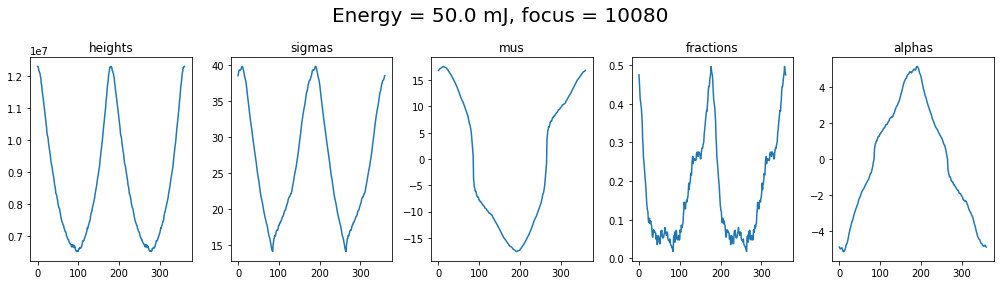

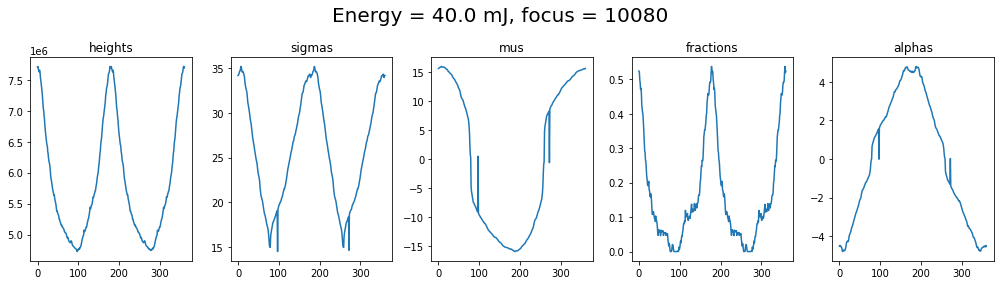

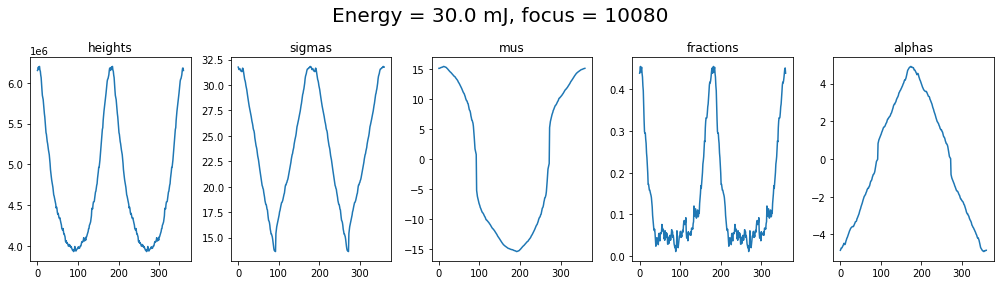

In [1071]:
synthetic_ims_param_test = synthetic_plasma_image_interpolating_generator(avgd_images_10180[0:3]
                                                                            ,[3]
                                                                            ,0.35
                                                                            ,False
                                                                            ,False)

for i,im10180 in enumerate(avgd_images_10180[0:3]):
    #fig,axs = plt.subplots(1,2,figsize = (20,10))
    #axs[0].imshow(synthetic_ims_param_interp_10080[0][i][0])
    #axs[1].imshow(im10080)
    #plt.show()
    titles = ['heights','sigmas','mus','fractions','alphas']
    fig,axs = plt.subplots(1,5,figsize = (14,4))
    for iv,val in enumerate(synthetic_ims_param_test[1][i]):
        for j,k in enumerate(val):
            if j >=1:
                #print(j-1)
                axs[j].plot(k)
                axs[j].set_title(titles[j])

        axs[0].plot(val[0])
        axs[0].set_title(titles[0])
        plt.suptitle('Energy = %.1f mJ, focus = 10080' %energies_10180[i],fontsize =20)
        fig.tight_layout()
        plt.show()

In [795]:
avgd_images_10180 = []
for i in range(0,int(len(images_10180)/5)):
    
    bound_avg = 230
    
    #print(i)
    blankim = np.zeros((bound_avg+bound_avg+1,bound_avg+bound_avg+1))
    print([5*i,5*(i+1)])
    for k in range(5*i,5*(i+1)):
        
        im = images[k]
        squimage = square_image_cropper(im,0.45)
        sq_cent = int(len(squimage)/2)
        sqscaled = squimage[sq_cent-bound_avg:sq_cent+bound_avg+1:,sq_cent-bound_avg:sq_cent+bound_avg+1]
        blankim+= sqscaled
    #plt.imshow(blankim)
    #plt.show()
    avgd_images_10180.append(blankim)
   

print('-------')

avgd_images_10080 = []
for i in range(0,int(len(images_10080)/5)):
    
    bound_avg = 230
    
    #print(i)
    blankim = np.zeros((bound_avg+bound_avg+1,bound_avg+bound_avg+1))
    print([5*i,5*(i+1)])
    for k in range(5*i,5*(i+1)):
        
        im = images[k]
        squimage = square_image_cropper(im,0.45)
        sq_cent = int(len(squimage)/2)
        sqscaled = squimage[sq_cent-bound_avg:sq_cent+bound_avg+1:,sq_cent-bound_avg:sq_cent+bound_avg+1]
        blankim+= sqscaled
    #plt.imshow(blankim)
    #plt.show()
    avgd_images_10080.append(blankim)

print('-----')
    
avgd_images_10100 = []
for i in range(0,int(len(images_10100)/5)):
    
    bound_avg = 230
    
    #print(i)
    blankim = np.zeros((bound_avg+bound_avg+1,bound_avg+bound_avg+1))
    print([5*i,5*(i+1)])
    for k in range(5*i,5*(i+1)):
        
        im = images[k]
        squimage = square_image_cropper(im,0.45)
        sq_cent = int(len(squimage)/2)
        sqscaled = squimage[sq_cent-bound_avg:sq_cent+bound_avg+1:,sq_cent-bound_avg:sq_cent+bound_avg+1]
        blankim+= sqscaled
    #plt.imshow(blankim)
    #plt.show()
    avgd_images_10100.append(blankim)
    
        
    

[0, 5]
[5, 10]
[10, 15]
[15, 20]
[20, 25]
[25, 30]
[30, 35]
[35, 40]
-------
[0, 5]
[5, 10]
[10, 15]
[15, 20]
[20, 25]
[25, 30]
[30, 35]
-----
[0, 5]
[5, 10]
[10, 15]
[15, 20]
[20, 25]
[25, 30]
[30, 35]


In [1124]:
#fraction_vals = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]#

#global_interpolated_10180 = []
#for fraction_val in fraction_vals:
#    print('Fraction Value = %.1f' %fraction_val)
#    print('-----')
#    synths_real = synthetic_plasma_image_interpolating_generator(avgd_images_10180
#                                                            ,[3]
#                                                            ,0.4
#                                                            ,False
#                                                            ,False)
    
#    global_interpolated_10180.append(synths_real)
    
    
    
#print('----')
#print('----')


fraction_vals = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]

global_interpolated_10080 = []
for fraction_val in fraction_vals:
    print('Fraction Value = %.1f' %fraction_val)
    print('-----')
    synths_real = synthetic_plasma_image_interpolating_generator(avgd_images_10080
                                                            ,[3]
                                                            ,0.4
                                                            ,False
                                                            ,False)
    
    global_interpolated_10080.append(synths_real)

Fraction Value = 1.0
-----
Square minimum 0.0
0
221105.71704250676
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
158375.4337789878
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
143310.0949601554
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
113981.17451294881
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
125417.72207926548
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
66310.74682974503
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
52464.2396684894
100
200
300
Number of fits 361
Run time Errors = 0
Fraction Value = 0.9
-----
Square minimum 0.0
0
221105.71704250676
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
158375.4337789878
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
143310.0949601554
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
113981.17451294881
100

Square minimum 0.0
0
[10888427.803562028, 43.41177054745232, 247.75318992471762, 0.5, -6.183816734366581]


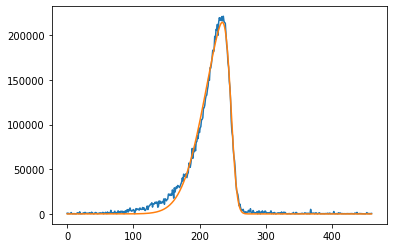

221105.71704250676
[10922061.247742916, 43.49546863930418, 247.82808357536018, 0.5, -6.182861109025298]


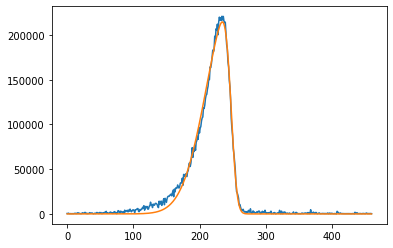

[10951736.649135262, 43.53144251593234, 247.89773926420588, 0.5, -6.150198673127942]


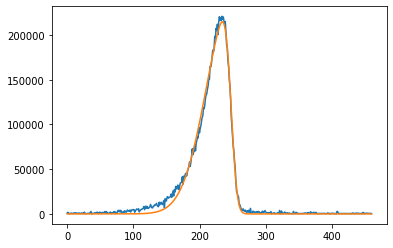

[10944270.267948668, 43.38493953703473, 247.93133554237892, 0.5, -6.073363240178548]


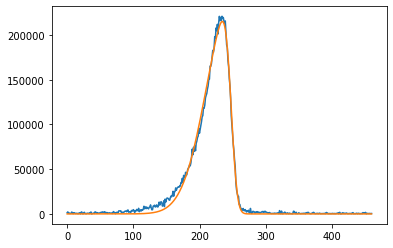

[10948066.417176299, 43.342836676241795, 247.9790119932345, 0.5, -6.018064877118406]


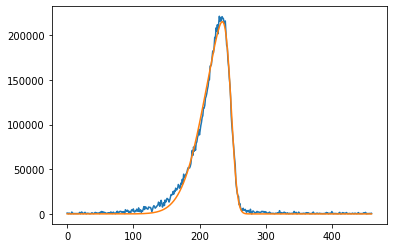

[10933728.380795488, 43.212822193793194, 248.0072235400454, 0.5, -5.952576300371341]


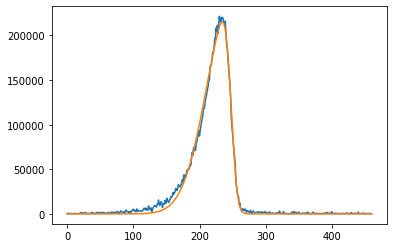

[10925372.518259706, 43.10735537319882, 248.03216872811788, 0.5, -5.9139490220122575]


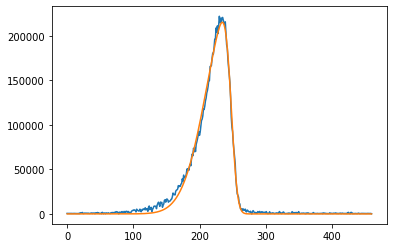

[10895091.481647551, 42.922107548591015, 248.028630933259, 0.5, -5.903275369418509]


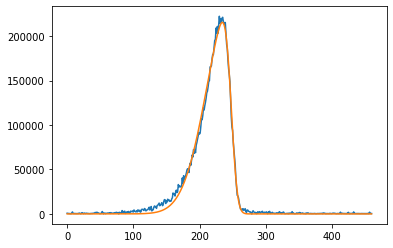

[10905047.024339046, 42.85921903056917, 248.05168347280892, 0.5, -5.915642800730336]


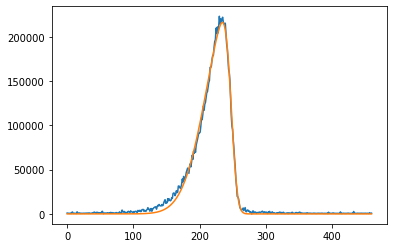

[10857982.792242886, 42.5970981428414, 248.0447750253271, 0.5, -5.893189257651784]


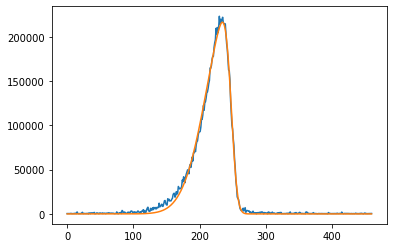

[10853747.165614638, 42.43416356181389, 248.07509649397346, 0.5, -5.841064784749651]


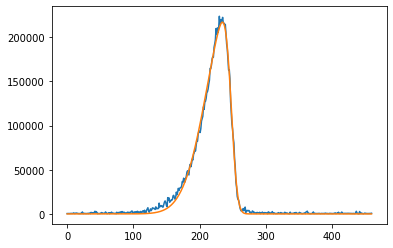

[10799758.934809137, 42.070401744919124, 248.05662213309176, 0.5, -5.756028333374749]


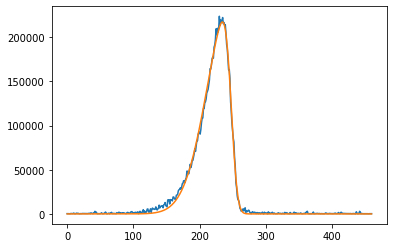

[10750607.816566126, 41.779072590592975, 248.0318511225404, 0.5, -5.702651456439461]


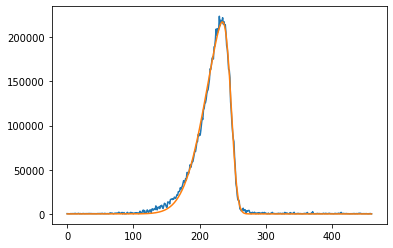

[10692318.934726741, 41.382998386491295, 247.97120424342754, 0.5, -5.622978522916595]


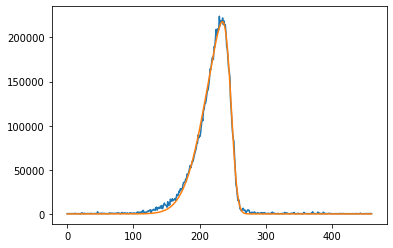

[10634210.97047954, 40.99516629286979, 247.91143273834638, 0.5, -5.532622432407299]


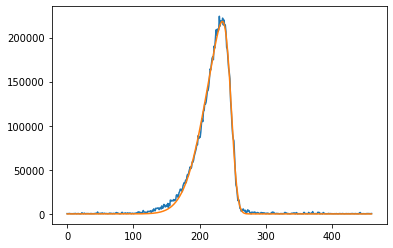

[10584196.020226946, 40.579162966261755, 247.85871708048768, 0.5, -5.396505514347942]


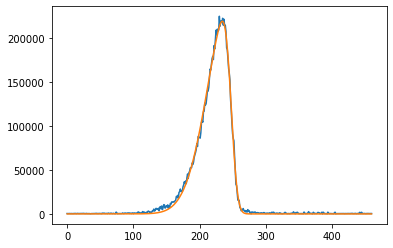

[10522040.526474169, 40.10707238566409, 247.80033484953583, 0.5, -5.239993287298898]


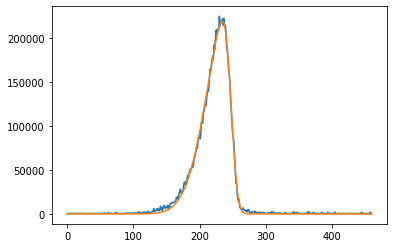

[10470464.406496326, 39.77595367001639, 247.75876112904297, 0.5, -5.1408881264055175]


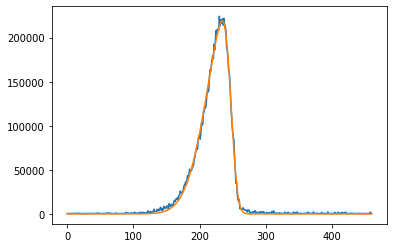

[10403992.388508905, 39.3814715564857, 247.69042858213555, 0.5, -5.050770566370906]


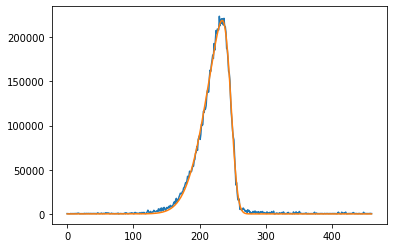

[10331995.253618944, 38.92049565014919, 247.59927330843698, 0.5, -4.9475022128446]


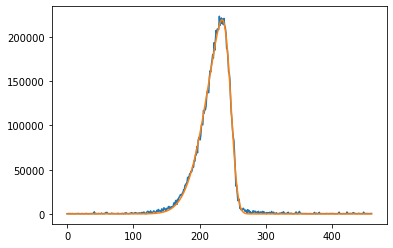

[10257804.983485099, 38.44522189787689, 247.49602803424085, 0.5, -4.840962032111898]


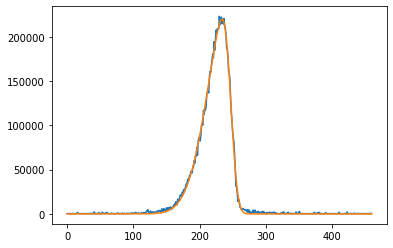

[10177017.474399356, 37.928991184102934, 247.38123207019555, 0.5, -4.720391712487066]


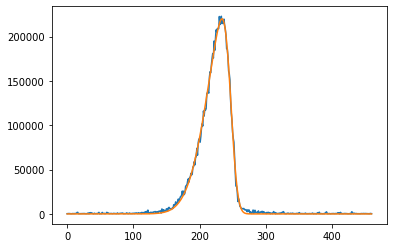

[10093211.885913065, 37.33831833103231, 247.24916960600626, 0.5, -4.570693264331556]


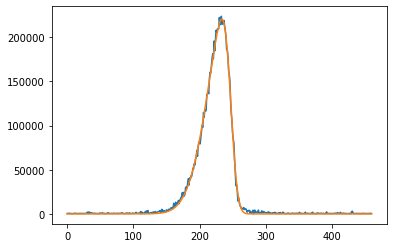

[9980657.773238197, 36.66387350465989, 247.09590529782506, 0.5, -4.412265448451519]


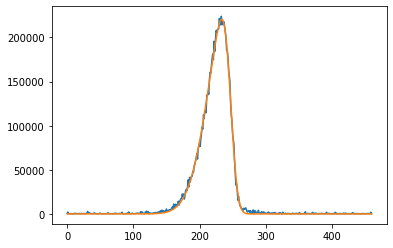

[9901885.444553524, 36.15073077720161, 246.98860508963662, 0.5, -4.2809390503621465]


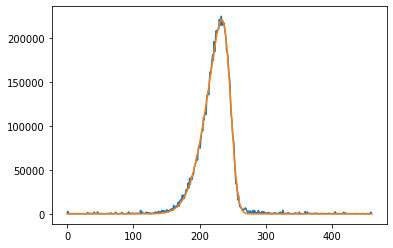

[9844698.122477604, 35.72610952965775, 246.90499157802287, 0.5, -4.162066039926519]


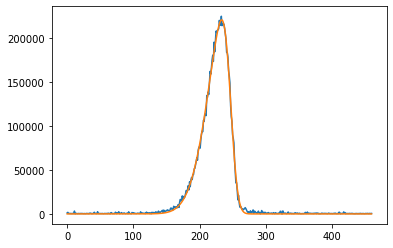

[9772637.054976137, 35.3121001506053, 246.80598406697874, 0.5, -4.0804407027799305]


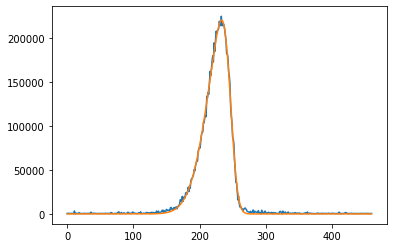

[9665609.976543484, 34.766228147409926, 246.66352651970703, 0.5, -3.9966225826957427]


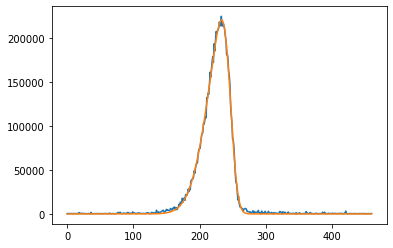

[9572498.053327441, 34.238555015099536, 246.54151046559525, 0.5, -3.9019047008458116]


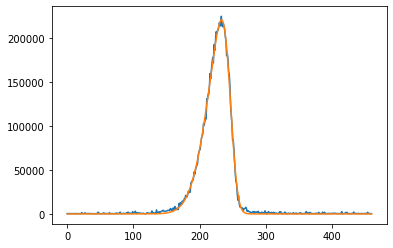

[9491426.442372799, 33.74521891484856, 246.43337133927716, 0.5, -3.8022833737424175]


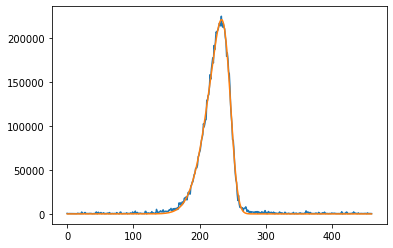

[9413444.647826238, 33.24619741688725, 246.30293864125898, 0.5, -3.6958149972431436]


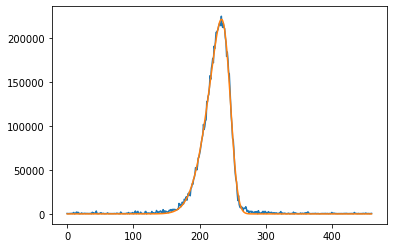

[9344615.587609485, 32.814717245785666, 246.1690340782324, 0.5, -3.6206868740785616]


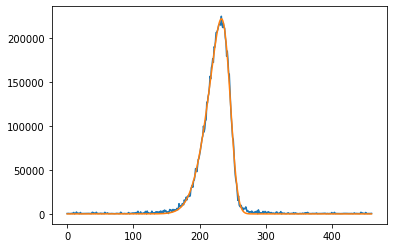

[9259964.460114287, 32.32003257598382, 246.0079941921781, 0.5, -3.547226436242523]


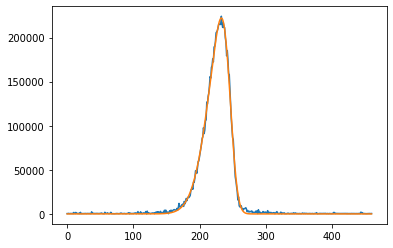

[9178554.730691362, 31.81015818688337, 245.85082180161731, 0.5, -3.438588857231407]


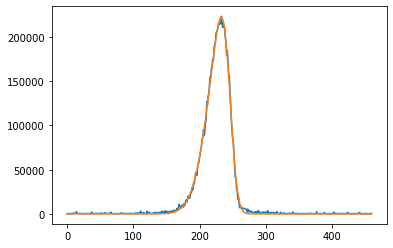

[9112951.535080565, 31.36646550728446, 245.7132685583113, 0.5, -3.3303138308017797]


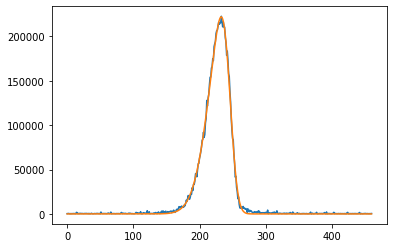

[9045090.11270876, 30.997194522933984, 245.5876090449748, 0.5, -3.268326548391798]


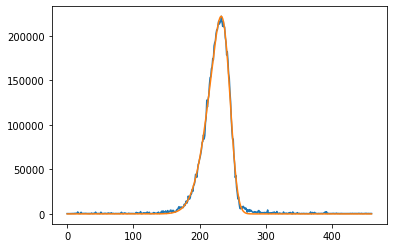

[8954467.115656316, 30.550754066042668, 245.42140186939525, 0.5, -3.2077041176165144]


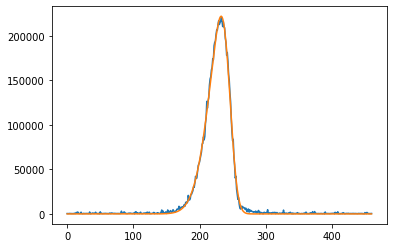

[8863474.688158879, 30.08396390330631, 245.24327873075242, 0.5, -3.136247894464635]


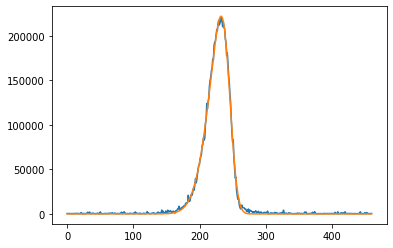

[8798332.052754357, 29.709283638874624, 245.11232379342485, 0.5, -3.0670648386911195]


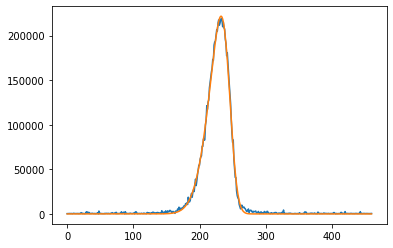

[8728539.199413834, 29.30808539369042, 244.98641300362723, 0.5, -2.9905469936032603]


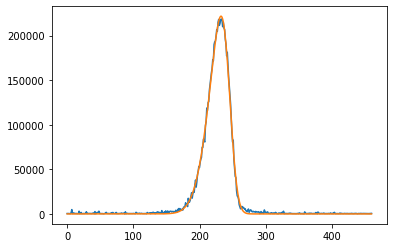

[8646600.0758866, 28.839039703034796, 244.8318293102493, 0.5, -2.9065469167602425]


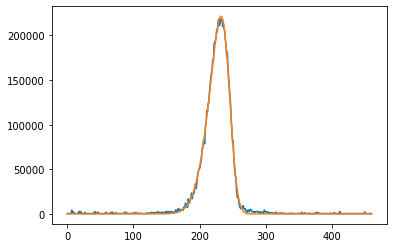

[8567043.863775898, 28.388329139457497, 244.6699885102654, 0.5, -2.8364785295838715]


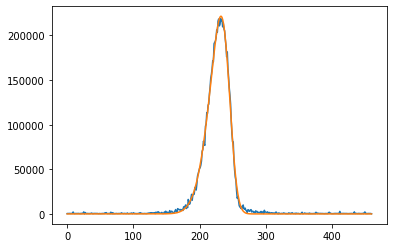

[8477995.863394596, 27.91710701291228, 244.4773245506651, 0.5, -2.7627285972918862]


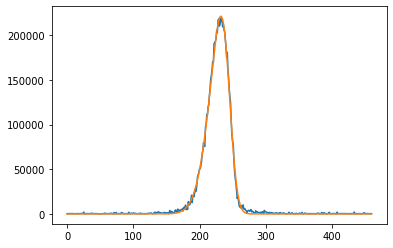

[8423700.016092705, 27.561624050670098, 244.31666816049284, 0.5, -2.697439960691871]


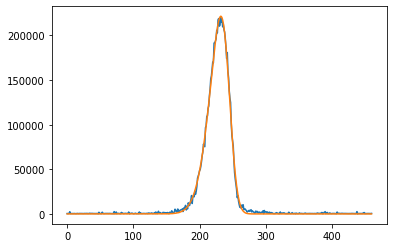

[8348666.436409047, 27.122854769834902, 244.11877351260836, 0.5, -2.6295632057414497]


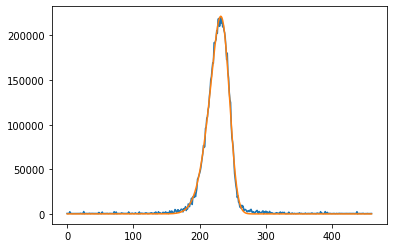

[8255298.397119153, 26.619977010457628, 243.9053260541337, 0.5, -2.5580560399443693]


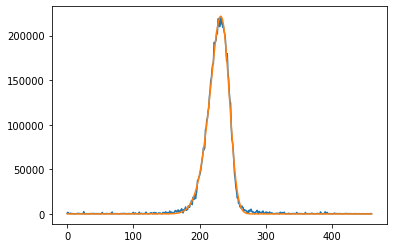

[8205215.064224694, 26.236584238181315, 243.75633726465819, 0.5, -2.483844988563023]


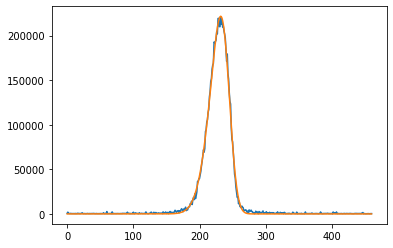

[8155474.10910242, 25.850887078270052, 243.60017463891228, 0.5, -2.4013344500813405]


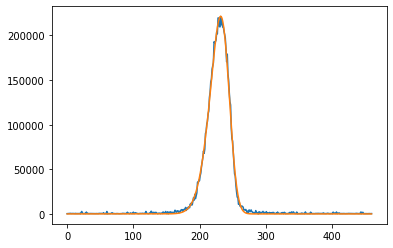

[8095942.451799876, 25.41878211487691, 243.40106914287173, 0.5, -2.321936118947148]


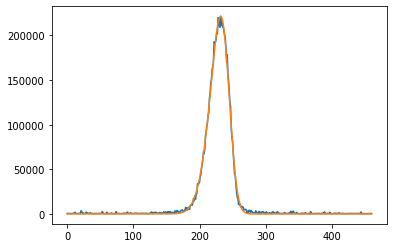

[8024493.769067588, 25.026526733061353, 243.20150352726125, 0.5, -2.2726489499351814]


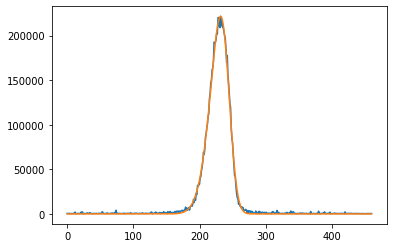

[7946938.2025700435, 24.623914170338015, 242.97100623315742, 0.5, -2.216478144682041]


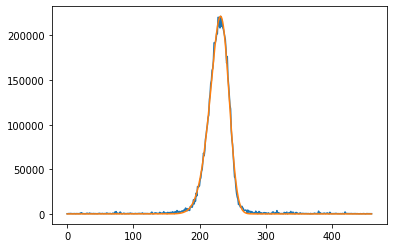

[7887450.297687789, 24.24762504188022, 242.74101877157233, 0.5, -2.1468660239415174]


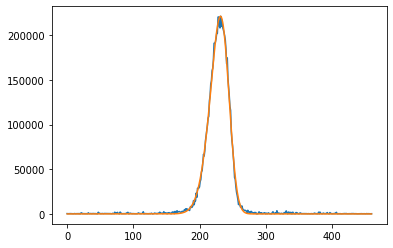

[7828775.617457916, 23.84978759989514, 242.50925016261323, 0.5, -2.0726470457899477]


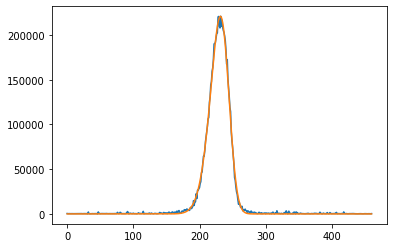

[7776085.408354982, 23.59284682934485, 242.37905623176582, 0.5, -2.0396501144979844]


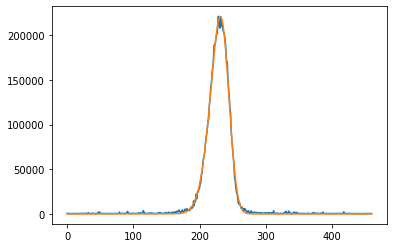

[7714799.658171365, 23.276983447177614, 242.2254346399846, 0.5, -2.000407323866612]


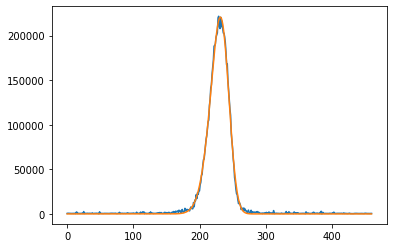

[7636503.990135593, 22.88898851226915, 242.0331865629782, 0.5, -1.9520575239328828]


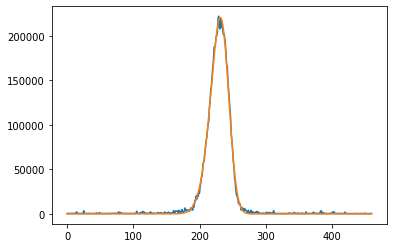

[7573928.943366771, 22.5247808927181, 241.84663694618877, 0.5, -1.90082349983967]


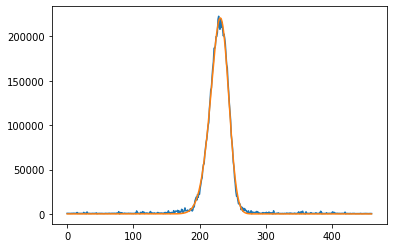

[7506550.136837642, 22.12259272038059, 241.62880170260252, 0.5, -1.839496362782005]


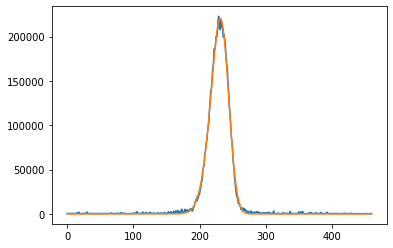

[7452138.264336025, 21.813645381439283, 241.459986813885, 0.5, -1.794336015541635]


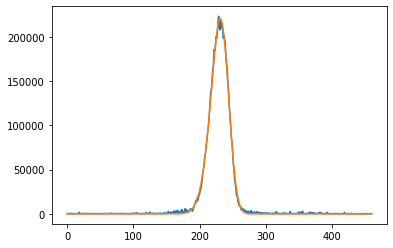

[7406367.306367114, 21.59038873959333, 241.3417546418159, 0.5, -1.7678499927412954]


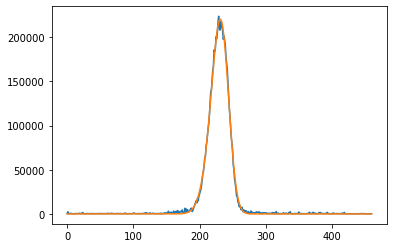

[7359160.770003035, 21.343405090492688, 241.20821800116295, 0.5, -1.7383356561716994]


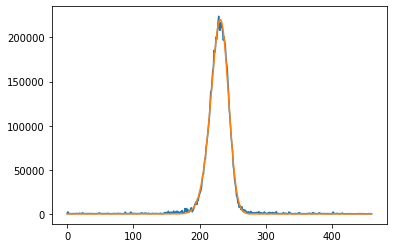

[7318383.601080534, 21.054255386103403, 241.04282918293765, 0.5, -1.695863233253549]


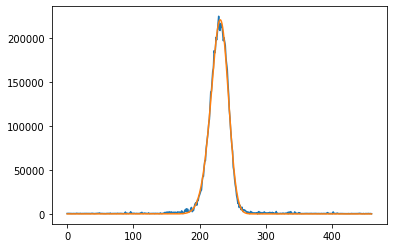

[7268489.112278985, 20.72468088517995, 240.8448885177885, 0.5, -1.6454466196390936]


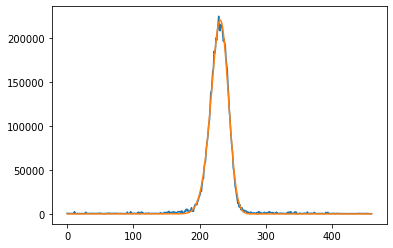

[7226704.404377103, 20.497999183345957, 240.70816623981804, 0.5, -1.6159141760913949]


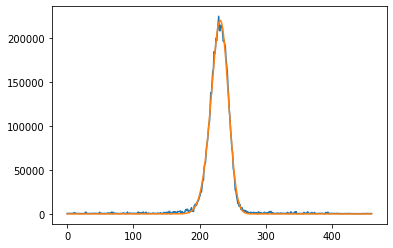

[7191238.250616634, 20.280976706607955, 240.56166868264302, 0.5, -1.5861094856736306]


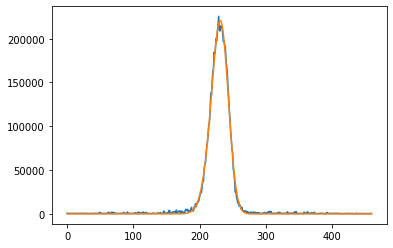

[7139247.889297991, 19.945442259164764, 240.31624607448083, 0.5, -1.532692354150515]


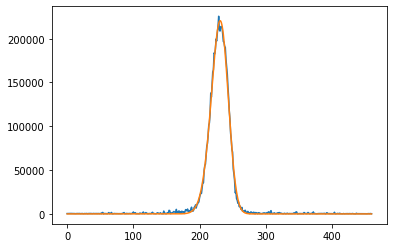

[7108506.153124382, 19.643443286940773, 240.07290102072932, 0.5, -1.4765379749324836]


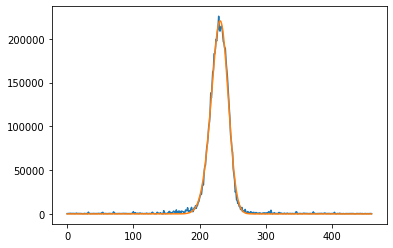

[7073745.652889565, 19.354132790478822, 239.83571196195447, 0.5, -1.4256290147428636]


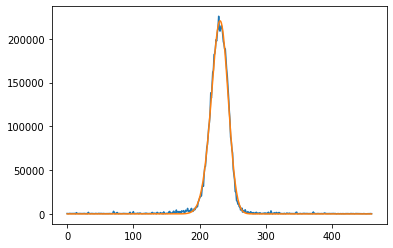

[7044616.461262858, 19.11758767334087, 239.6365764777516, 0.5, -1.3856633463677959]


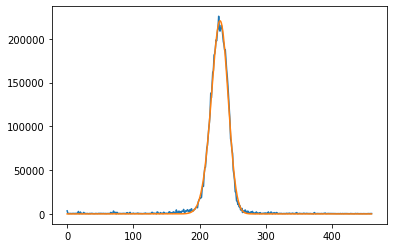

[7024734.835331475, 18.92863718065999, 239.4708524142873, 0.5, -1.3531028955972602]


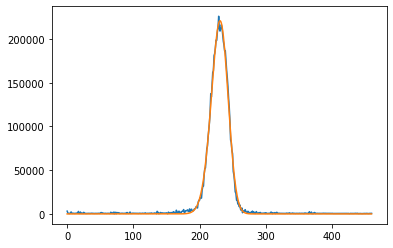

[6988497.327906751, 18.695387743869897, 239.27254201668978, 0.5, -1.314897062639373]


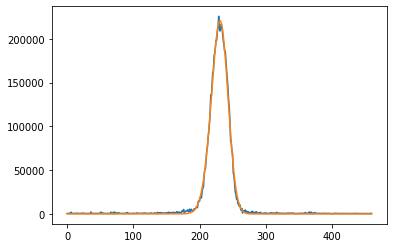

[6940021.562457009, 18.39665914038508, 239.0125672954275, 0.5, -1.2644824176176996]


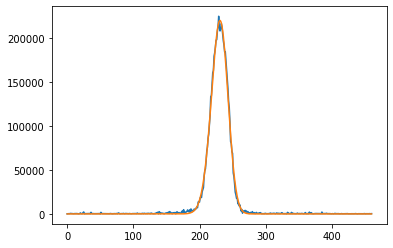

[6908243.977922502, 18.090285860310566, 238.71946707841906, 0.5, -1.2052373967256305]


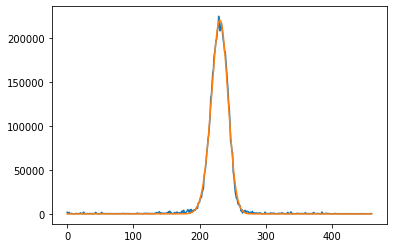

[6880183.794522933, 17.73689150493906, 238.36013043817997, 0.5, -1.1329365581994484]


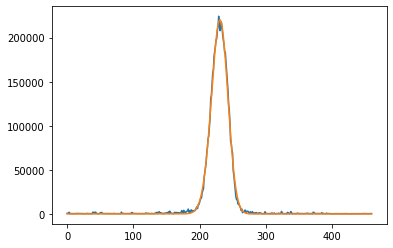

[6851588.461912727, 17.360373866320675, 237.9586050365598, 0.5, -1.0543208124357886]


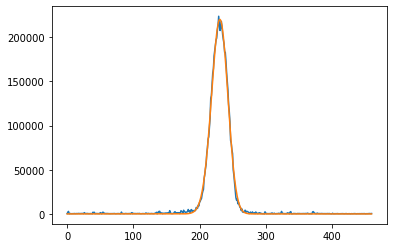

[6827171.297033271, 17.02951276665405, 237.58656379476977, 0.5, -0.9840759895127373]


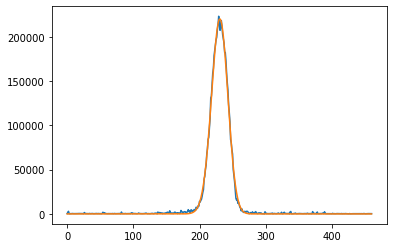

[6815806.015049116, 16.813589806214726, 237.33158837604122, 0.5, -0.9370315260679529]


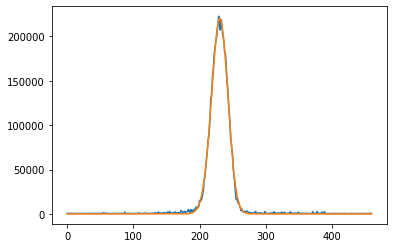

[6781878.073585473, 16.578925316721026, 237.07504634813165, 0.5, -0.893452554241918]


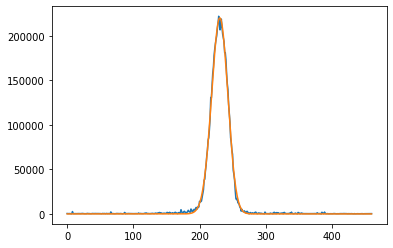

[6756461.980223344, 16.31105732267287, 236.73839537690037, 0.5, -0.8352134160619507]


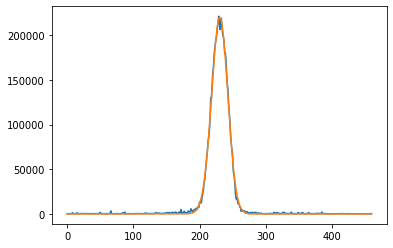

[6738078.127114527, 15.985334091166266, 236.26634123043368, 0.5, -0.7552367855930076]


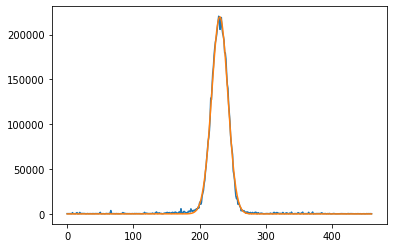

[6722044.712649042, 15.639043107356883, 235.70098497280796, 0.5, -0.6640324986499238]


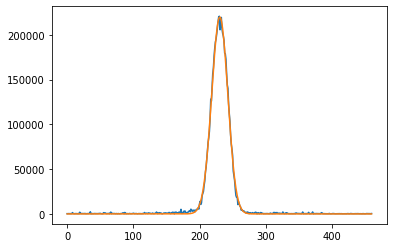

[6701522.213577034, 15.201800957510622, 234.85562308426933, 0.5, -0.5374560335725871]


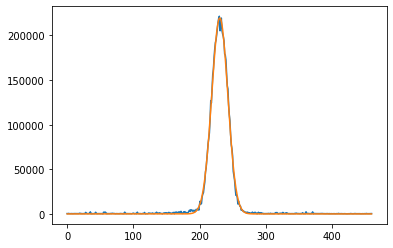

KeyboardInterrupt: 

In [1091]:
synthetic_ims_param_interp_10180 = synthetic_plasma_image_interpolating_generator(avgd_images_10180
                                                                            ,[3]
                                                                            ,0.35
                                                                            ,False
                                                                            ,False)

synthetic_ims_param_interp_10080 = synthetic_plasma_image_interpolating_generator(avgd_images_10080
                                                                            ,[3]
                                                                            ,0.35
                                                                            ,False
                                                                            ,False)

synthetic_ims_param_interp_10100 = synthetic_plasma_image_interpolating_generator(avgd_images_10100
                                                                            ,[3]
                                                                            ,0.35
                                                                            ,False
                                                                            ,False)



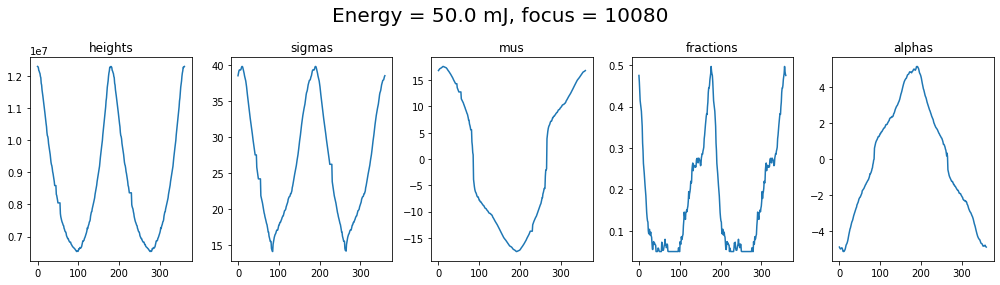

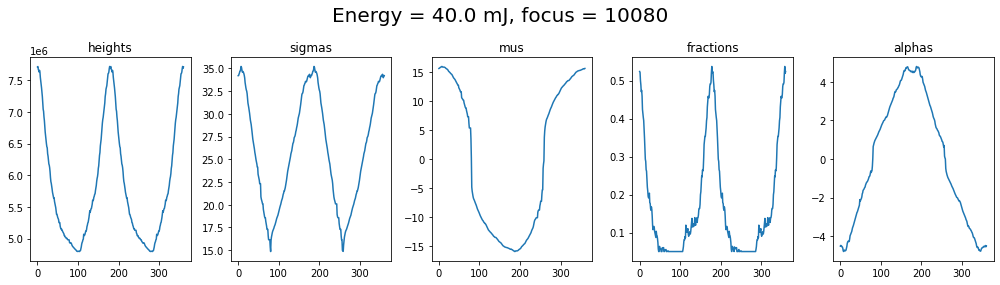

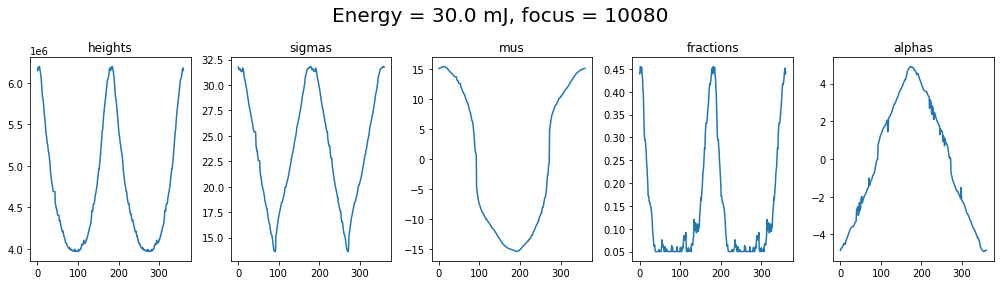

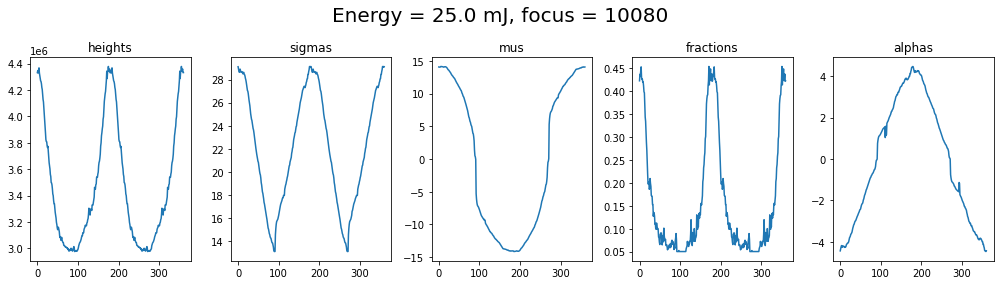

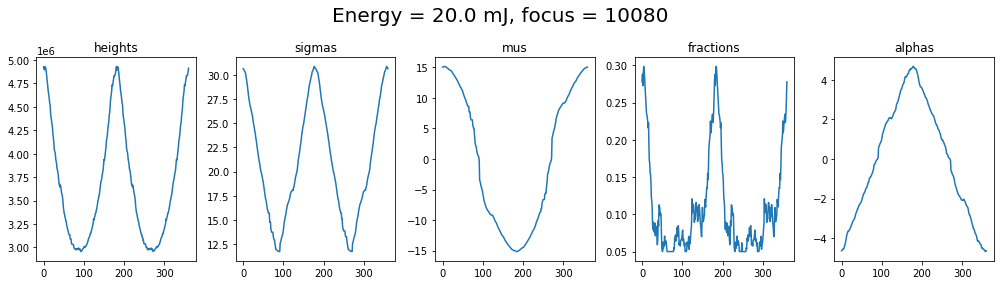

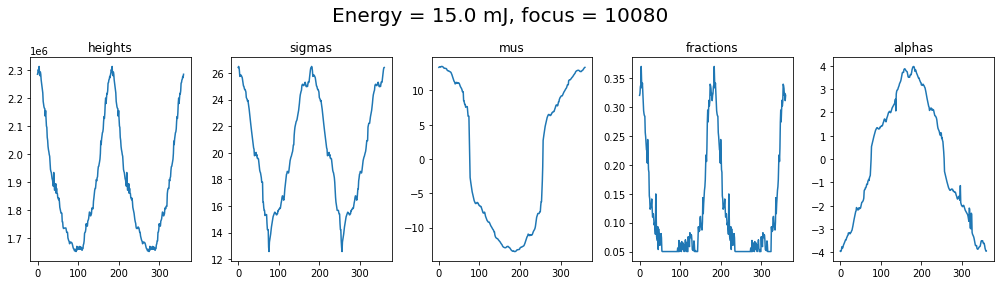

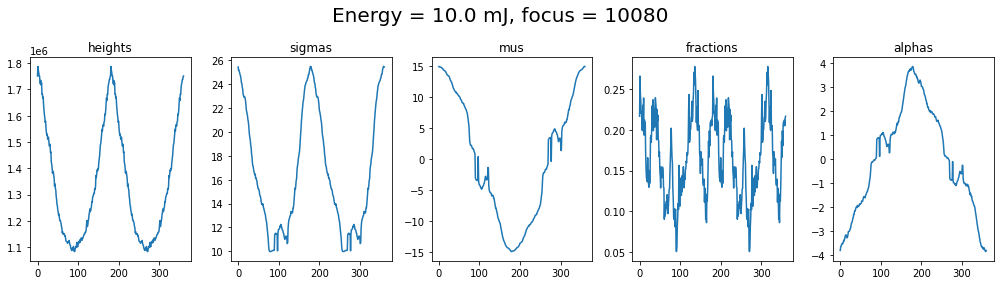

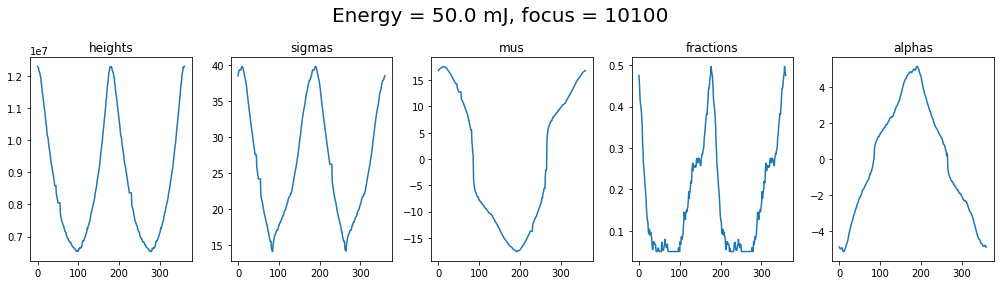

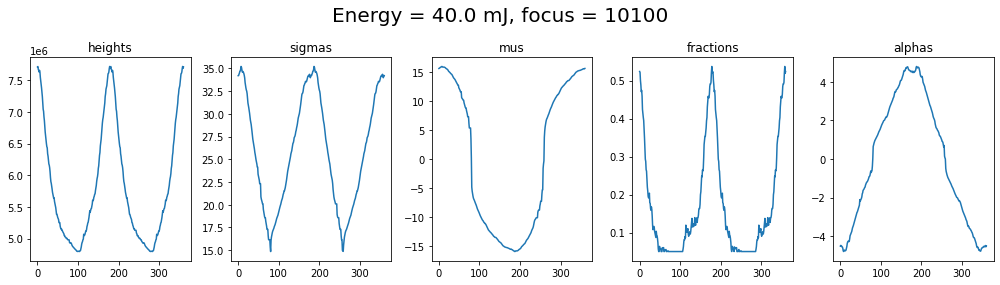

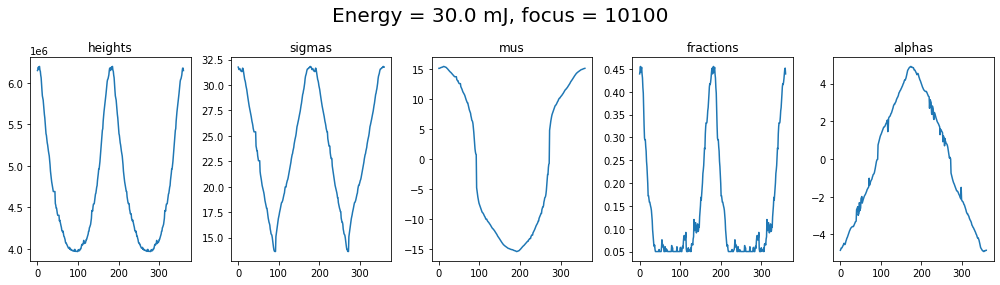

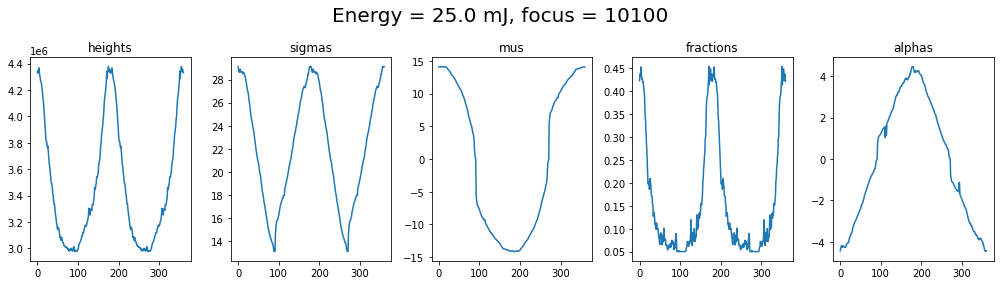

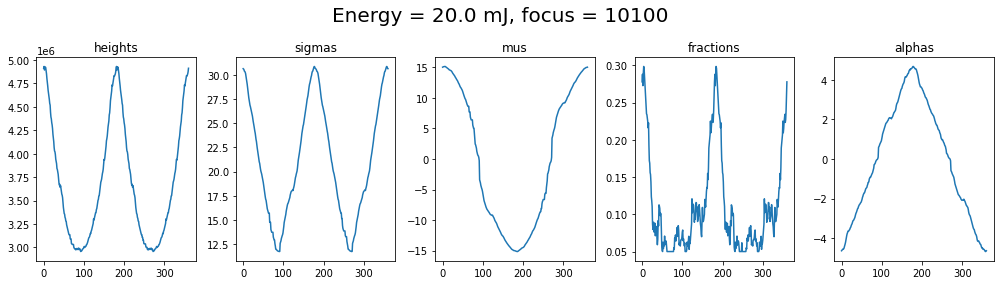

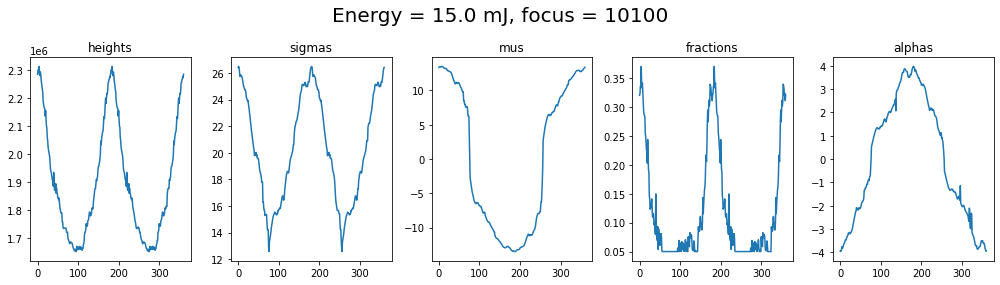

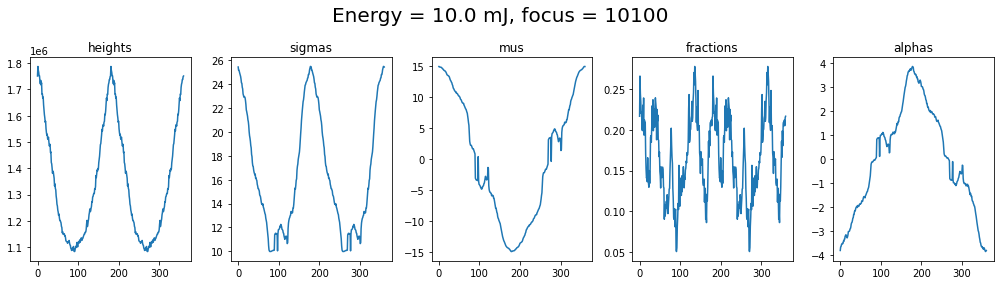

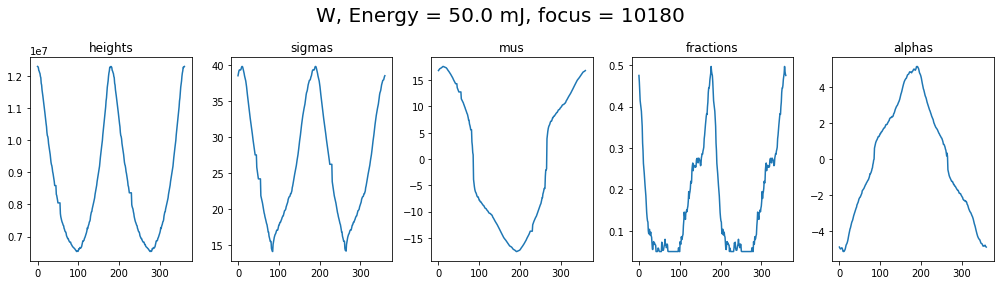

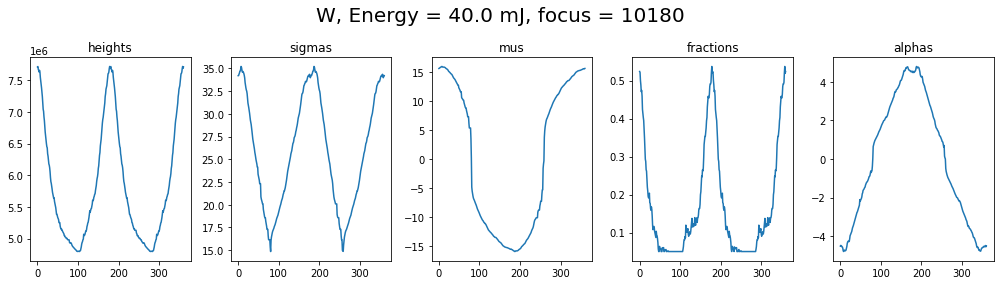

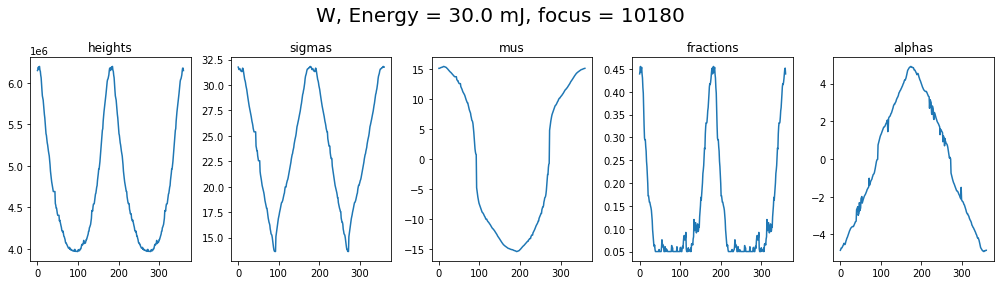

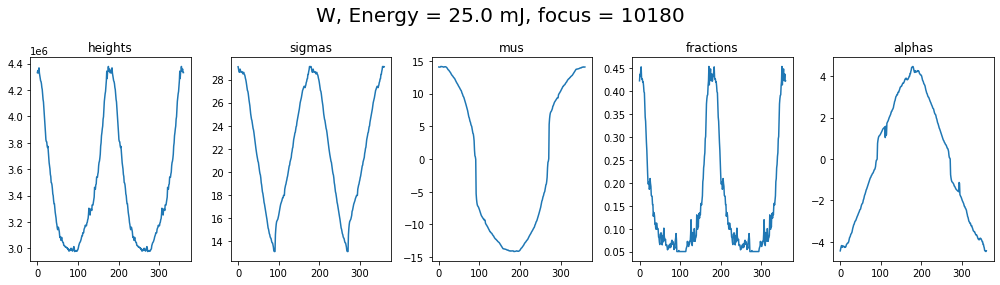

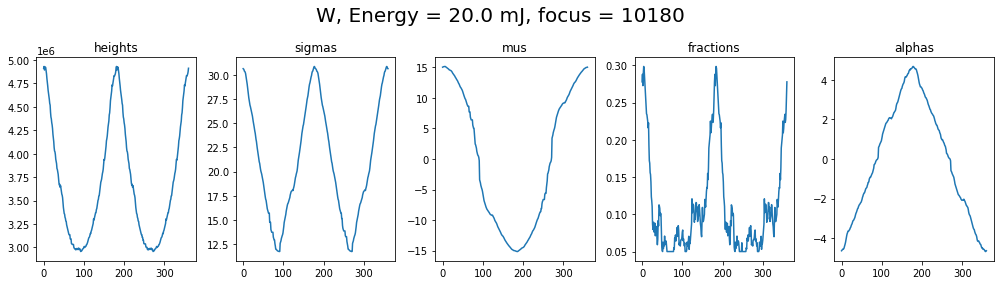

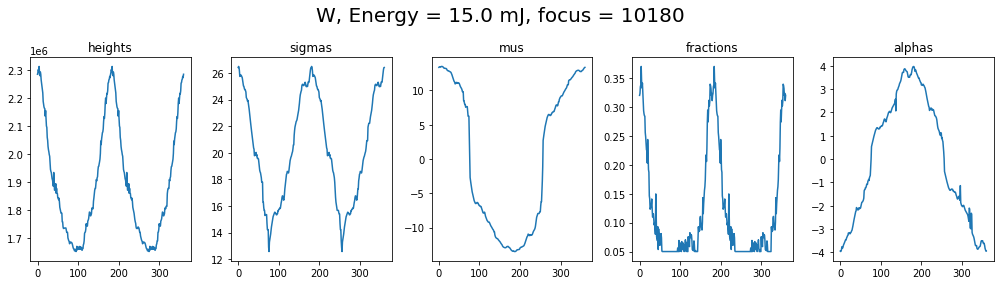

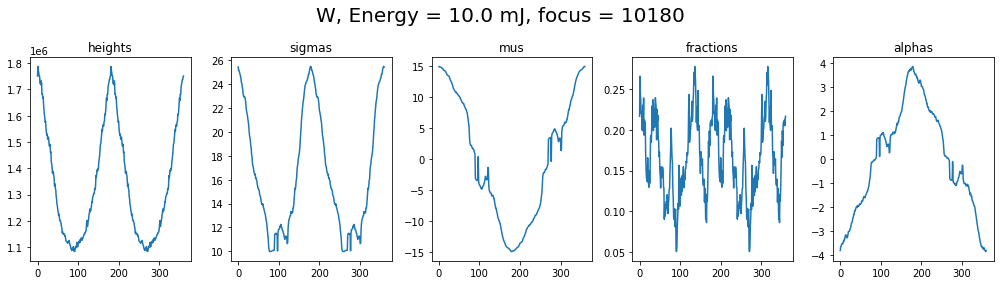

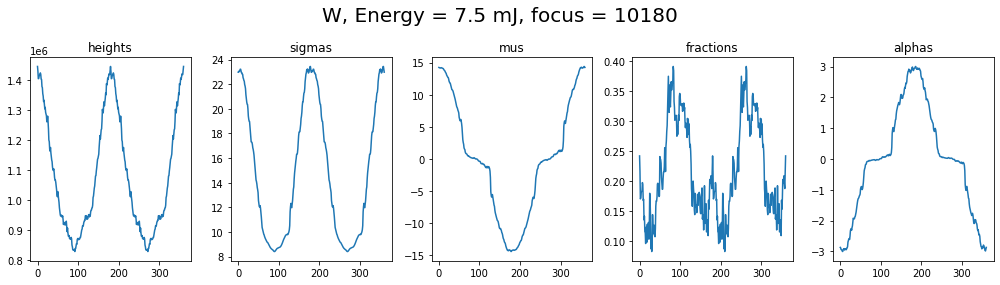

UsageError: Line magic function `%%capture` not found.


In [1160]:
for i,im10080 in enumerate(avgd_images_10080):
    #fig,axs = plt.subplots(1,2,figsize = (20,10))
    #axs[0].imshow(synthetic_ims_param_interp_10080[0][i][0])
    #axs[1].imshow(im10080)
    #plt.show()
    titles = ['heights','sigmas','mus','fractions','alphas']
    fig,axs = plt.subplots(1,5,figsize = (14,4))
    for iv,val in enumerate(synthetic_ims_param_interp_10080[1][i]):
        for j,k in enumerate(val):
            if j >=1:
                #print(j-1)
                axs[j].plot(k)
                axs[j].set_title(titles[j])

        axs[0].plot(val[0])
        axs[0].set_title(titles[0])
        plt.suptitle('Energy = %.1f mJ, focus = 10080' %energies_10080[i],fontsize =20)
        fig.tight_layout()
        plt.show()
        

for i,im10100 in enumerate(avgd_images_10100):
    #fig,axs = plt.subplots(1,2,figsize = (20,10))
    #axs[0].imshow(synthetic_ims_param_interp_10180[0][i][0])
    #axs[1].imshow(im10180)
    #plt.show()
    titles = ['heights','sigmas','mus','fractions','alphas']
    fig,axs = plt.subplots(1,5,figsize = (14,4))
    for iv,val in enumerate(synthetic_ims_param_interp_10100[1][i]):
        for j,k in enumerate(val):
            if j >=1:
                #print(j-1)
                plt.suptitle('Energy = %.1f mJ, focus = 10100' %energies_10100[i],fontsize =20)
                axs[j].plot(k)
                axs[j].set_title(titles[j])

        axs[0].plot(val[0])
        axs[0].set_title(titles[0])
        fig.tight_layout()
        plt.show()

        
        
for i,im10180 in enumerate(avgd_images_10180):
    #fig,axs = plt.subplots(1,2,figsize = (20,10))
    #axs[0].imshow(synthetic_ims_param_interp_10180[0][i][0])
    #axs[1].imshow(im10180)
    #plt.show()
    titles = ['heights','sigmas','mus','fractions','alphas']
    fig,axs = plt.subplots(1,5,figsize = (14,4))
    for iv,val in enumerate(synthetic_ims_param_interp_10180[1][i]):
        for j,k in enumerate(val):
            if j >=1:
                #print(j-1)
                plt.suptitle('W, Energy = %.1f mJ, focus = 10180' %energies_10180[i],fontsize =20)
                axs[j].plot(k)
                axs[j].set_title(titles[j])

        axs[0].plot(val[0])
        axs[0].set_title(titles[0])
        fig.tight_layout()
        plt.show()
        
        
        
%%capture cap

UsageError: %%capture is a cell magic, but the cell body is empty.


[222080.89728565622, 246491.0]


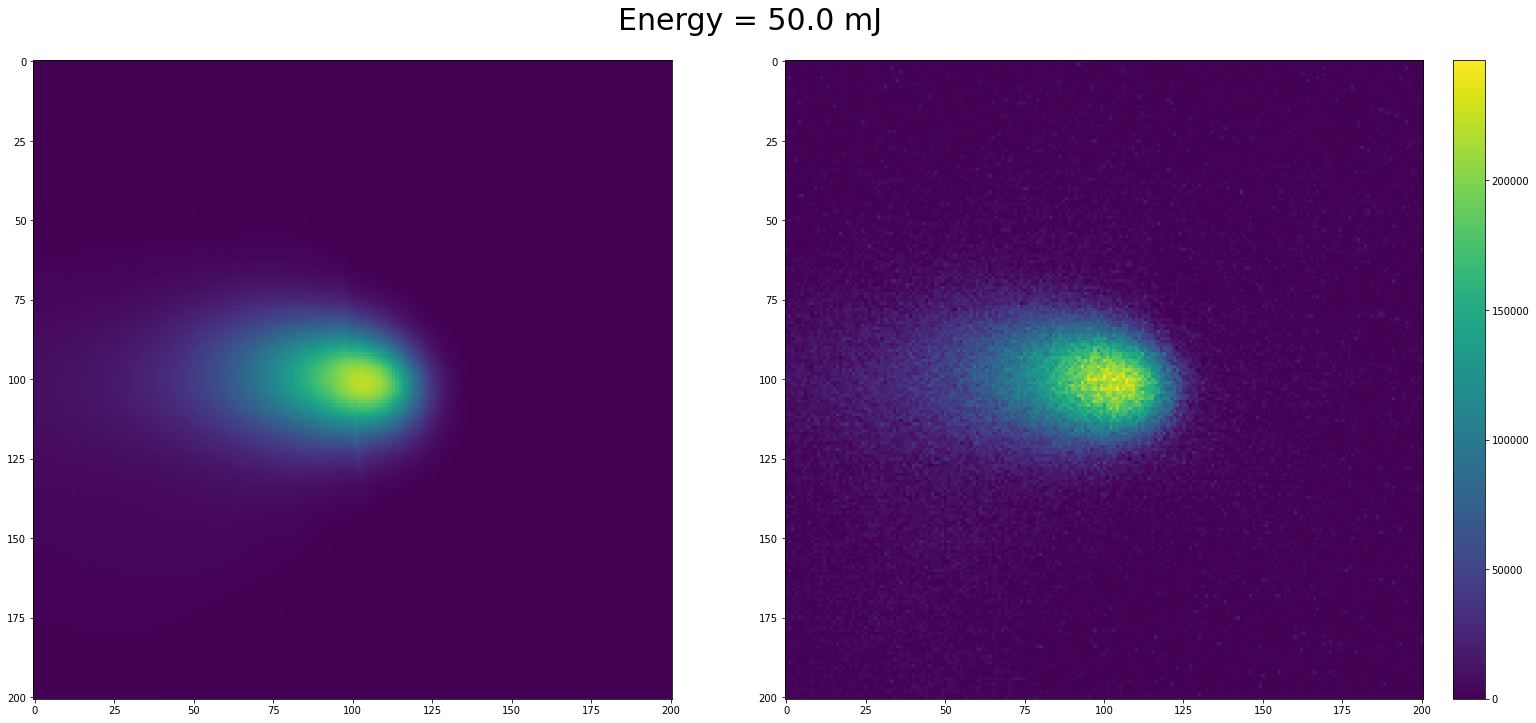

[159289.66938920904, 188445.0]


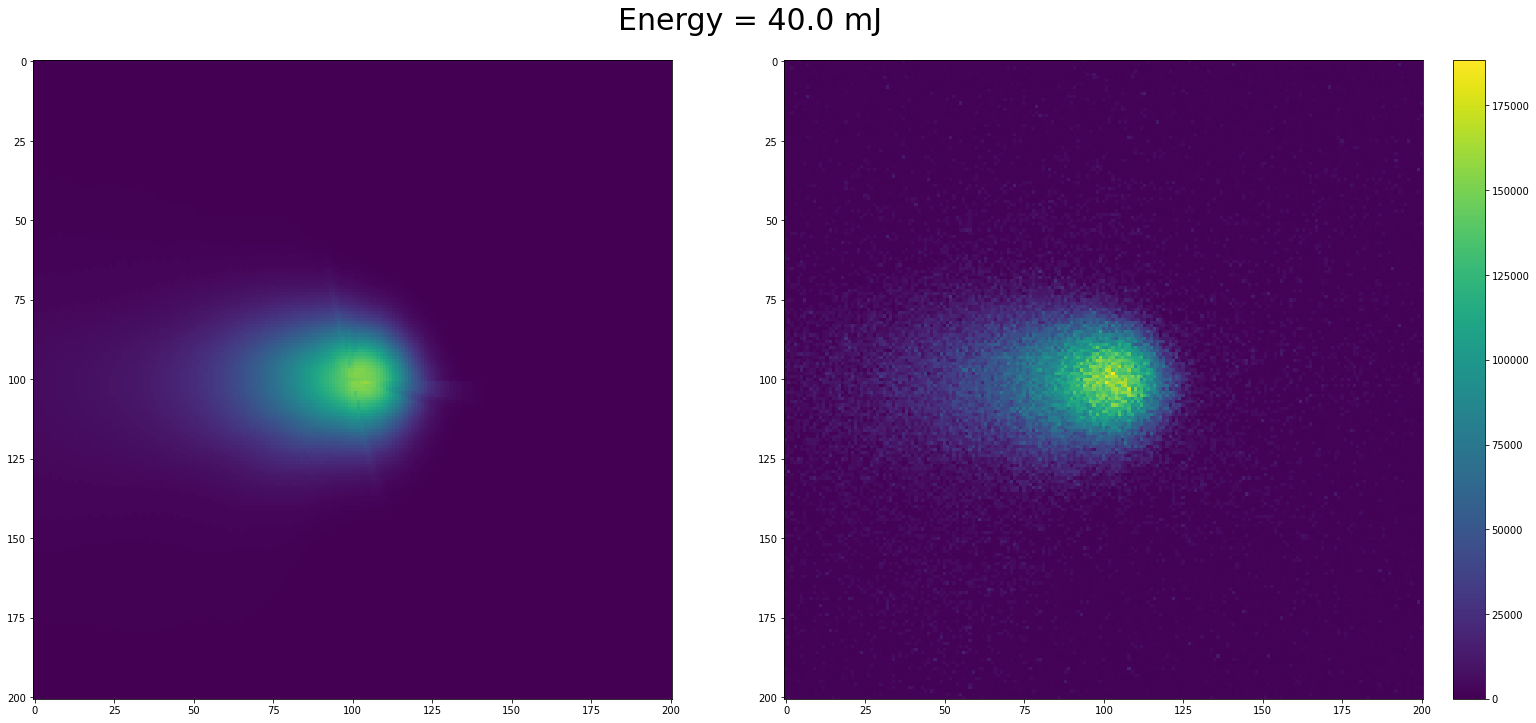

[140946.51375577395, 169912.0]


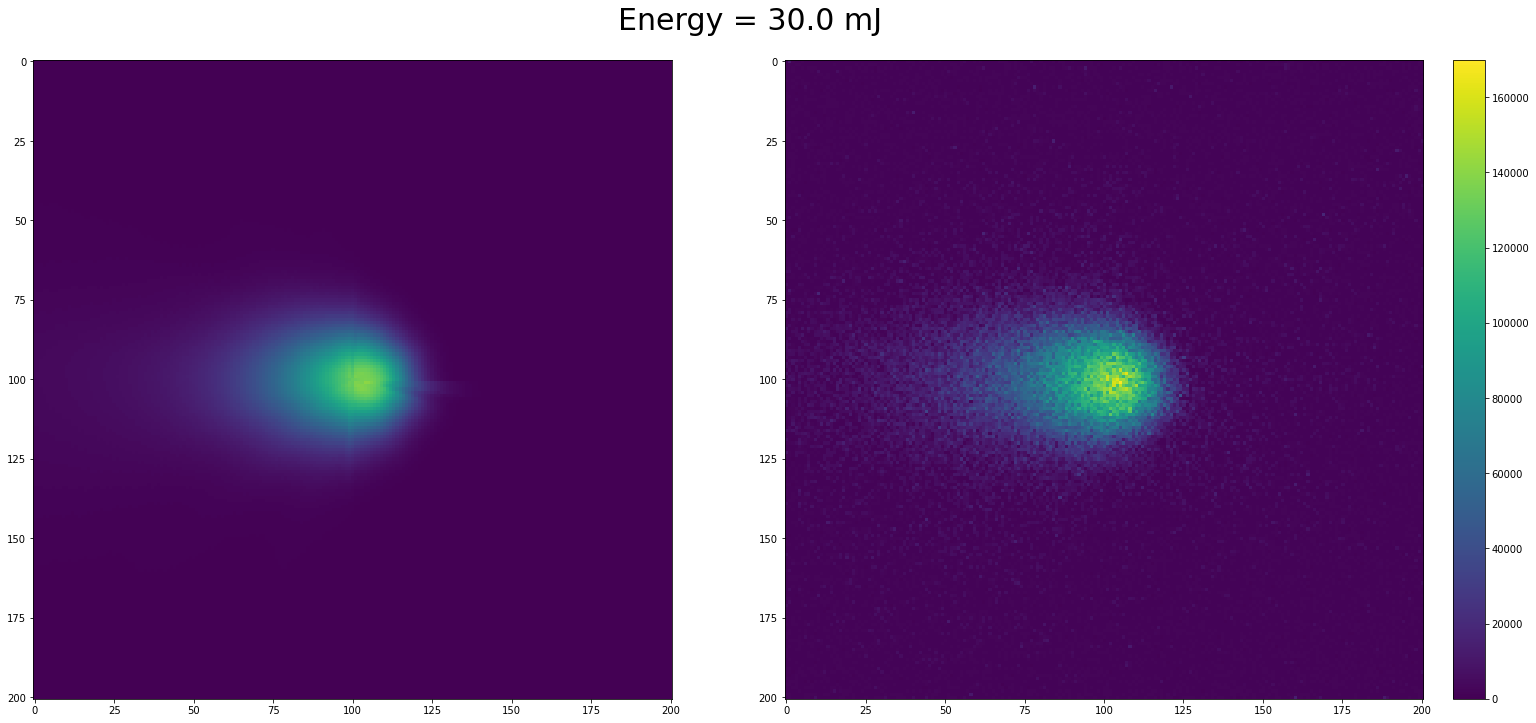

[108241.54926635363, 128381.0]


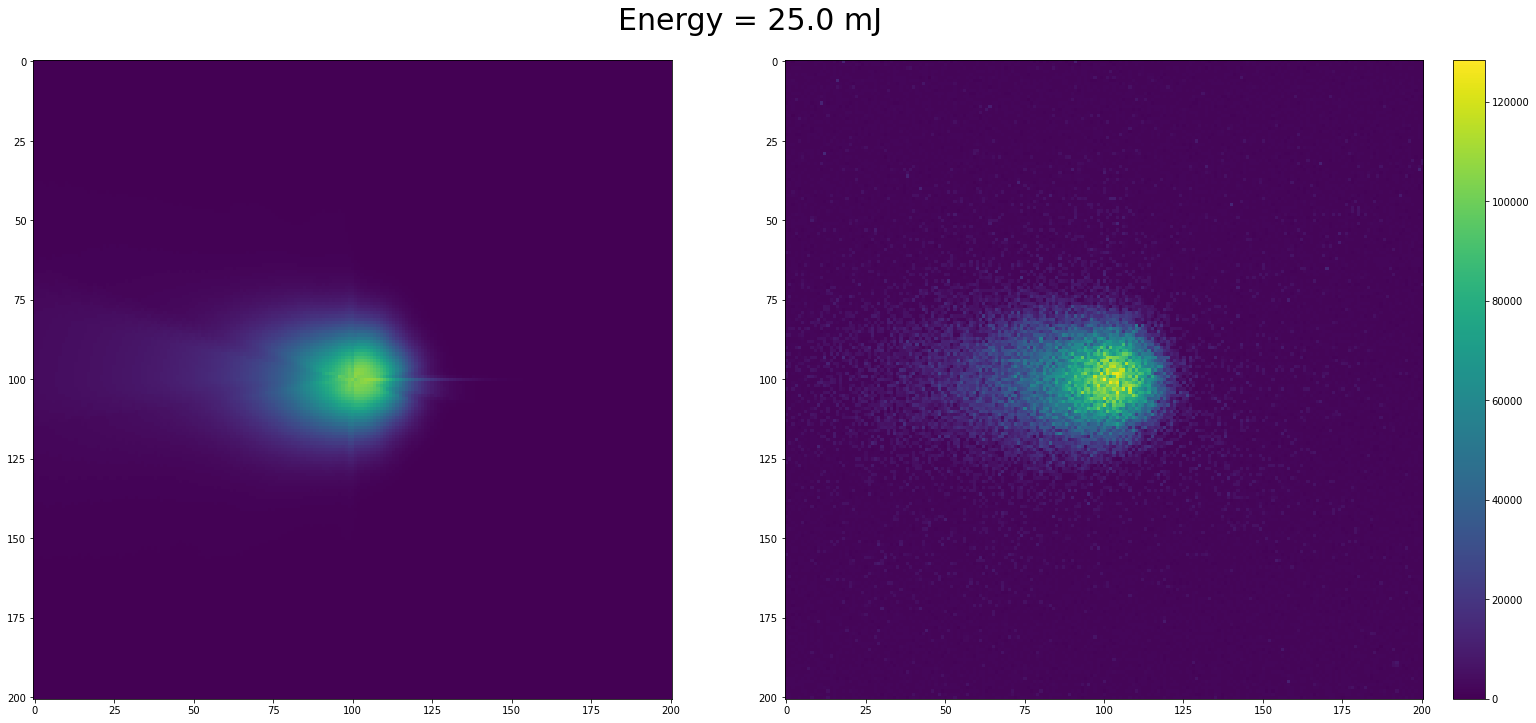

[120473.02637221428, 146194.0]


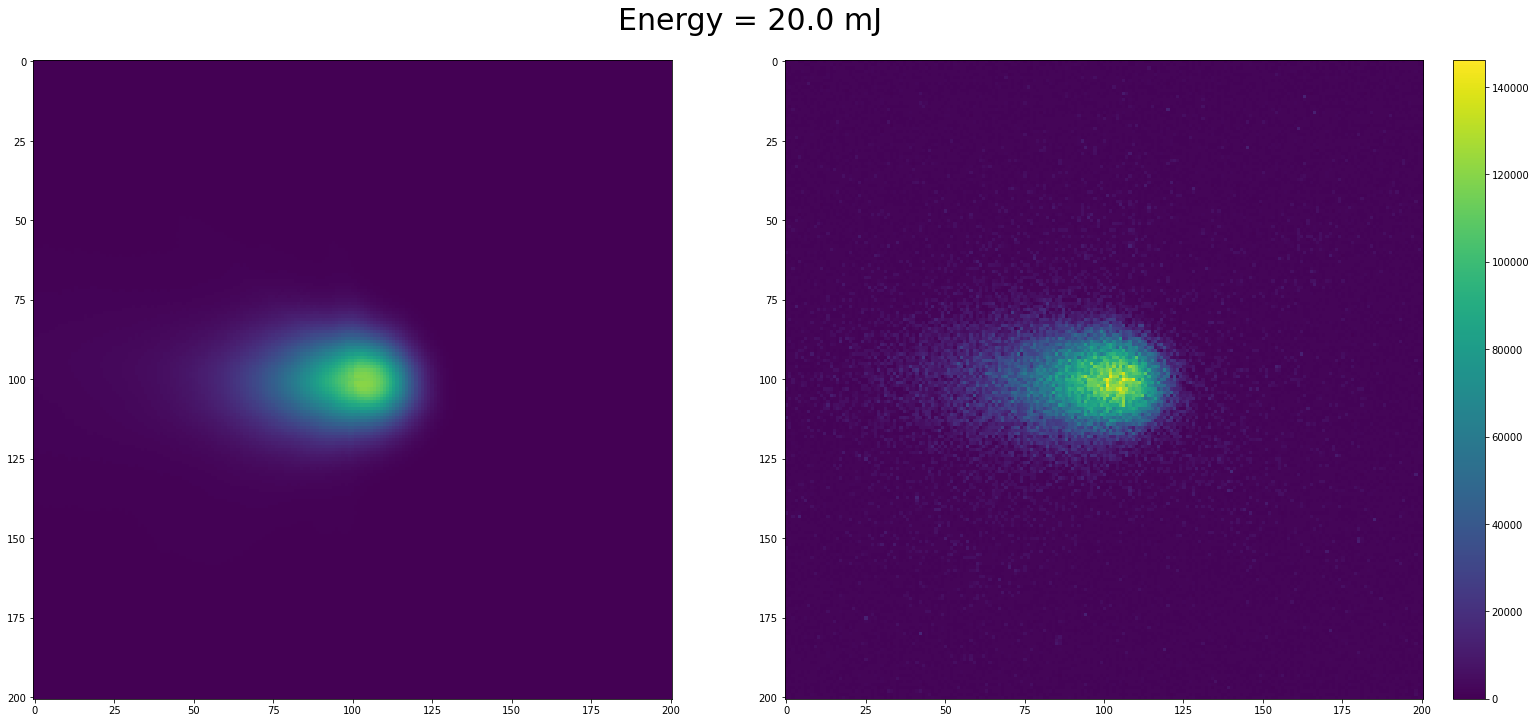

[62418.945186076686, 80642.0]


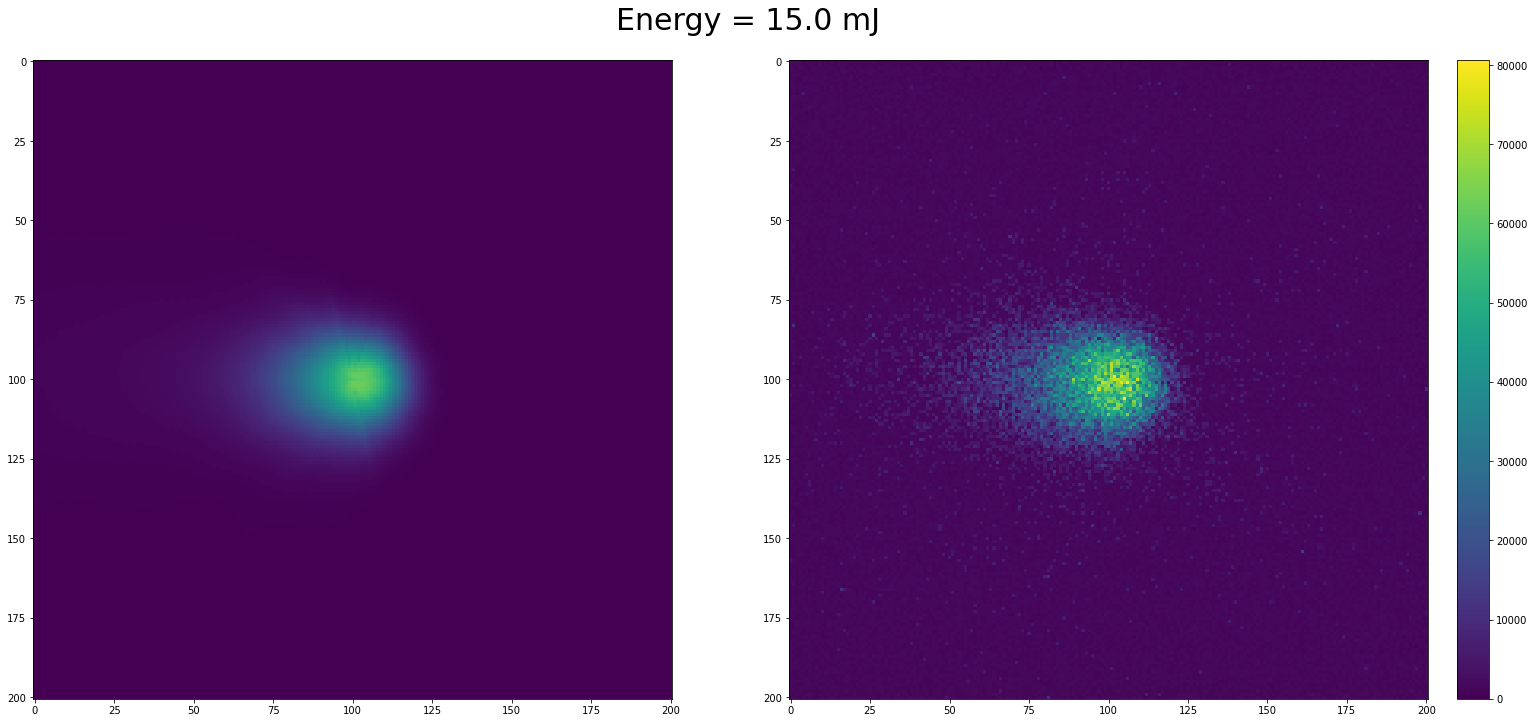

[51247.81751902007, 71408.0]


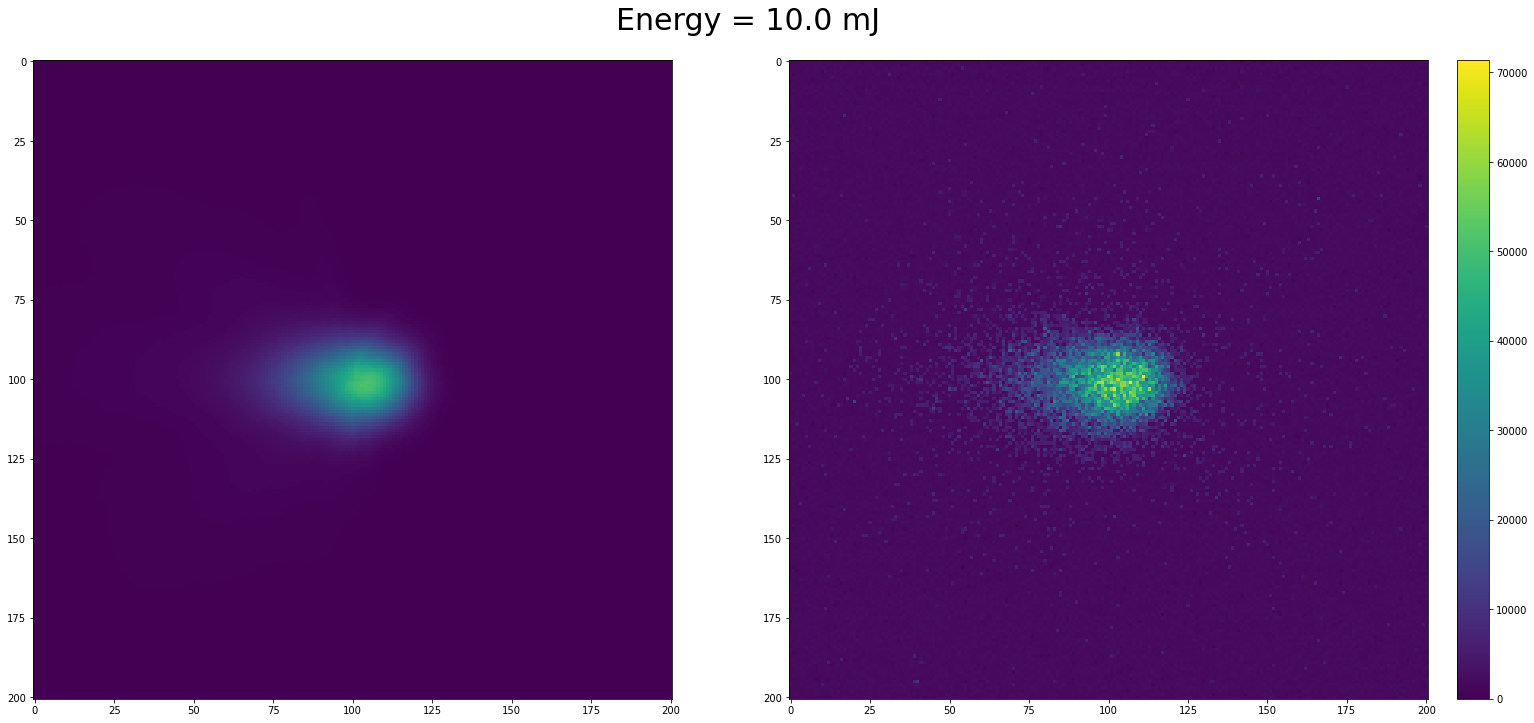

[42856.61626426165, 63070.0]


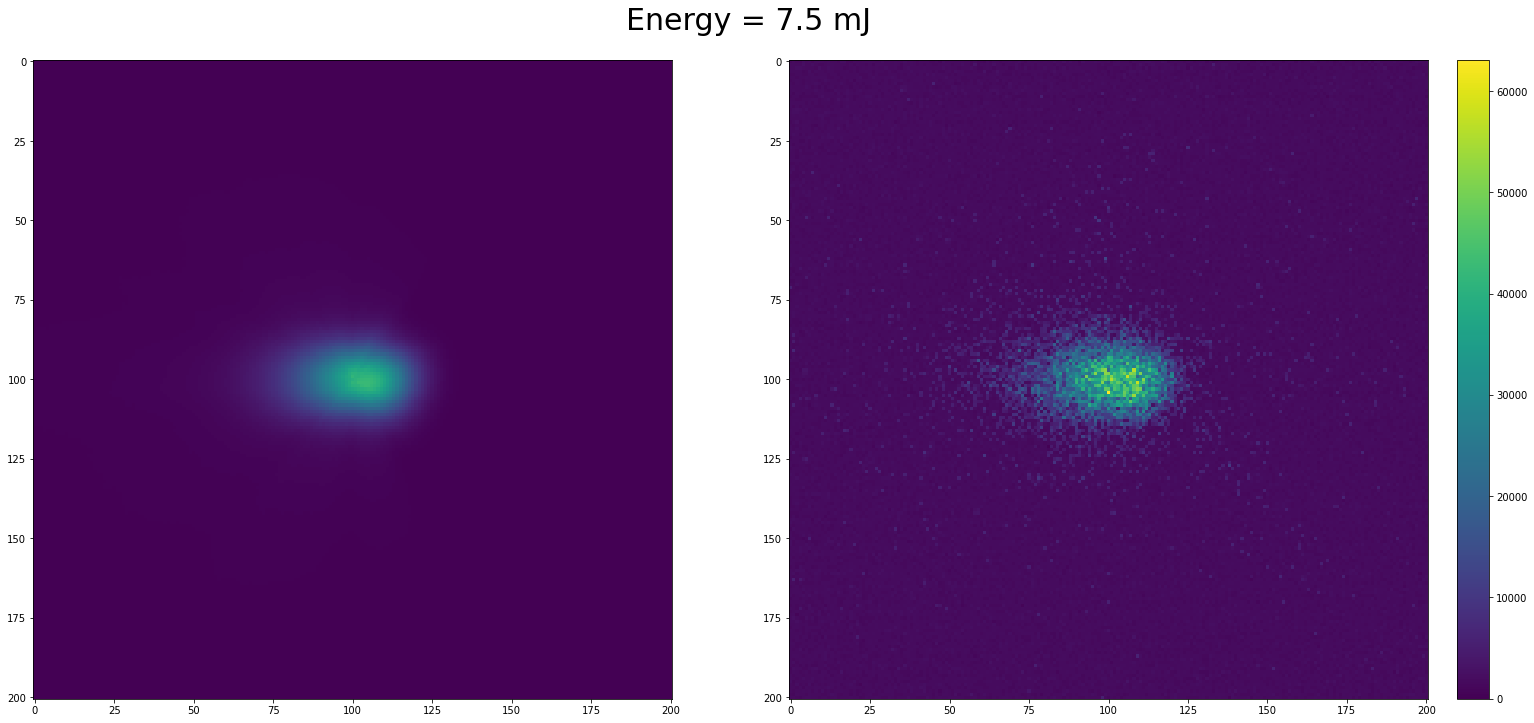

In [722]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for i,k in enumerate(synths_with_interpolation[0]):
    fig,axs = plt.subplots(1,2,figsize = (22,10))
    
    max_intensity = max(np.max(k[0]),np.max(avgd_images[i]))
    print([np.max(k[0]),np.max(avgd_images[i])])
    cent = int(len(k[0])/2)
    inf = cent - 100
    sup = cent + 100 + 1
    
    
    a = axs[0].imshow(k[0][inf:sup:,inf:sup],vmin=0, vmax=1*max_intensity)
    b = axs[1].imshow(avgd_images[i][inf:sup:,inf:sup],vmin = 0,vmax = 1*max_intensity)
    plt.suptitle('Energy = %.1f mJ'%energies[i],y = 1,fontsize = 30)
    
    #divider = make_axes_locatable(axs)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cbar.ax.tick_params(labelsize=10)
    fig.colorbar(b, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()

0
1
2
3


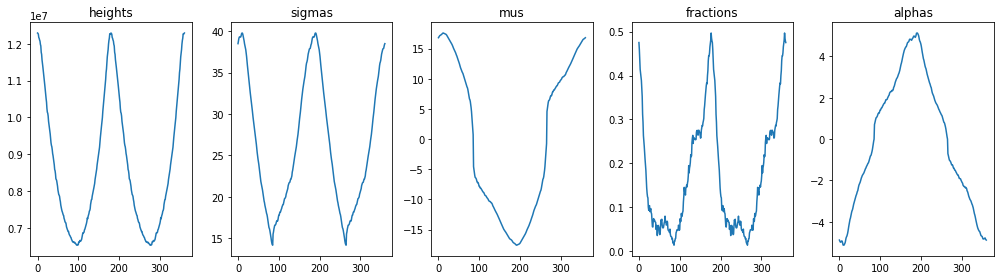

In [1045]:
titles = ['heights','sigmas','mus','fractions','alphas']
fig,axs = plt.subplots(1,5,figsize = (14,4))
for i,val in enumerate(synths_with_interpolation[1][0]):
    for j,k in enumerate(val):
        if j >=1:
            print(j-1)
            axs[j].plot(k)
            axs[j].set_title(titles[j])
    
    axs[0].plot(val[0])
    axs[0].set_title(titles[0])
    fig.tight_layout()
    plt.show()

In [1110]:
global_interpolated_10180

[]

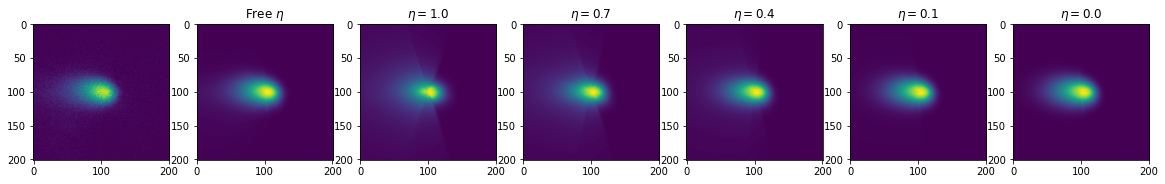

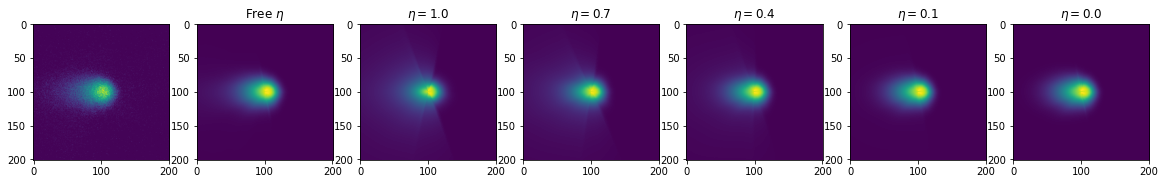

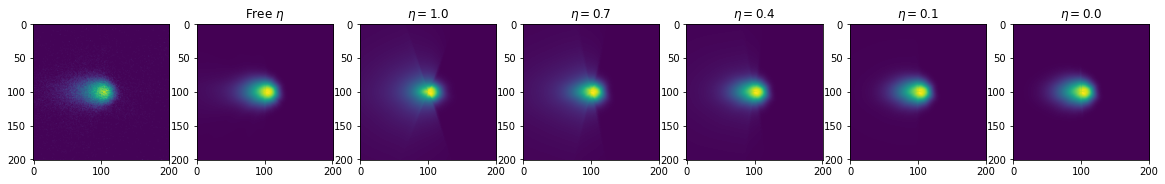

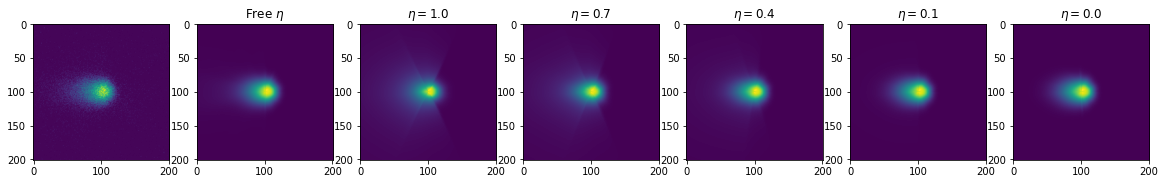

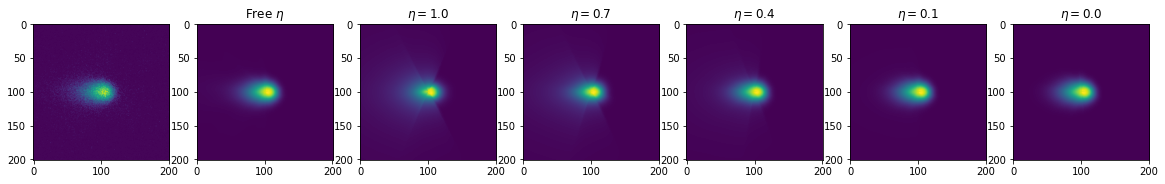

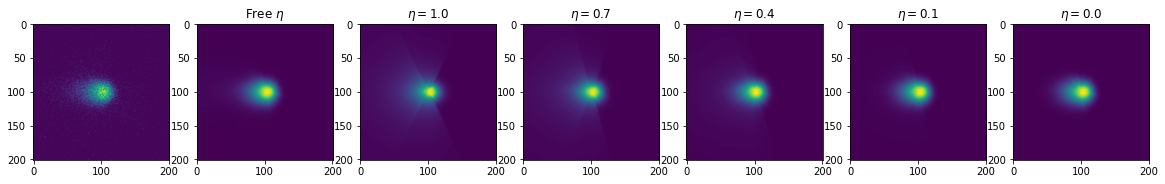

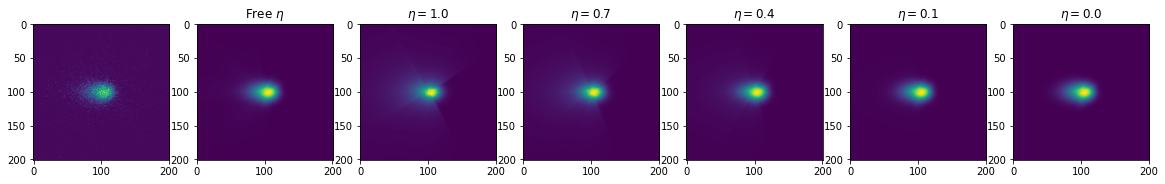

In [1125]:
for i,img in enumerate(avgd_images_10080):
    fig,axs = plt.subplots(1,7,figsize = (20,10))
    c = int(len(img)/2)
    bound = 100
    js = [0,3,6,9,10]
    free_eta_img = synthetic_ims_param_interp_10080[0][i][0][c-bound:c+bound+1:,c-bound:c+bound+1]
    axs[0].imshow(img[c-bound:c+bound+1:,c-bound:c+bound+1])
    axs[1].set_title(r'Free $\eta$')
    axs[1].imshow(free_eta_img)
    for j,k in enumerate(js):
        sy_img = global_interpolated_10080[k][0][i][0]
        axs[j+2].imshow(sy_img[c-bound:c+bound+1:,c-bound:c+bound+1])
        axs[j+2].set_title(r'$\eta = %.1f$'%fraction_vals[k])
    plt.show()

In [1135]:
synths_real_10080 = synthetic_plasma_image_interpolating_generator(avgd_images_10080
                                                                  ,[3]
                                                                  ,0.4
                                                                  ,False
                                                                  ,False)

Square minimum 0.0
0
221105.71704250676
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
158375.4337789878
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
143310.0949601554
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
113981.17451294881
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
125417.72207926548
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
66310.74682974503
100
200
300
Number of fits 361
Run time Errors = 0
Square minimum 0.0
0
52464.2396684894
100
200
300
Number of fits 361
Run time Errors = 0


In [1147]:
len(avgd_images_10080),len(energies),len(global_interpolated_10080[0][0])

difference

[12822.370900763512,
 11500.9,
 11501.5,
 11559.18,
 11646.86,
 11772.54,
 11942.84,
 12160.64,
 12419.95,
 12725.69,
 13061.01,
 13425.01]

\begin{equation}
\chi^{2} = \sum_{ij} \frac{(O_{ij} - C_{ij})^{2}}{var^{2}} = \sum_{ij} \frac{(O_{ij} - C_{ij})^{2}}{standev^{4}} = \sum_{ij} \frac{(O_{ij} - C_{ij})^{2}}{(\sqrt{counts})^{4}} = \sum_{ij} \frac{(O_{ij} - C_{ij})^{2}}{counts^{2}} \longrightarrow \sum_{ij} \frac{(O_{ij} - C_{ij})^{2}}{counts^{2} + 1}
\end{equation}

0.0
0.0
0.0
0.0
0.0
0.0
0.0


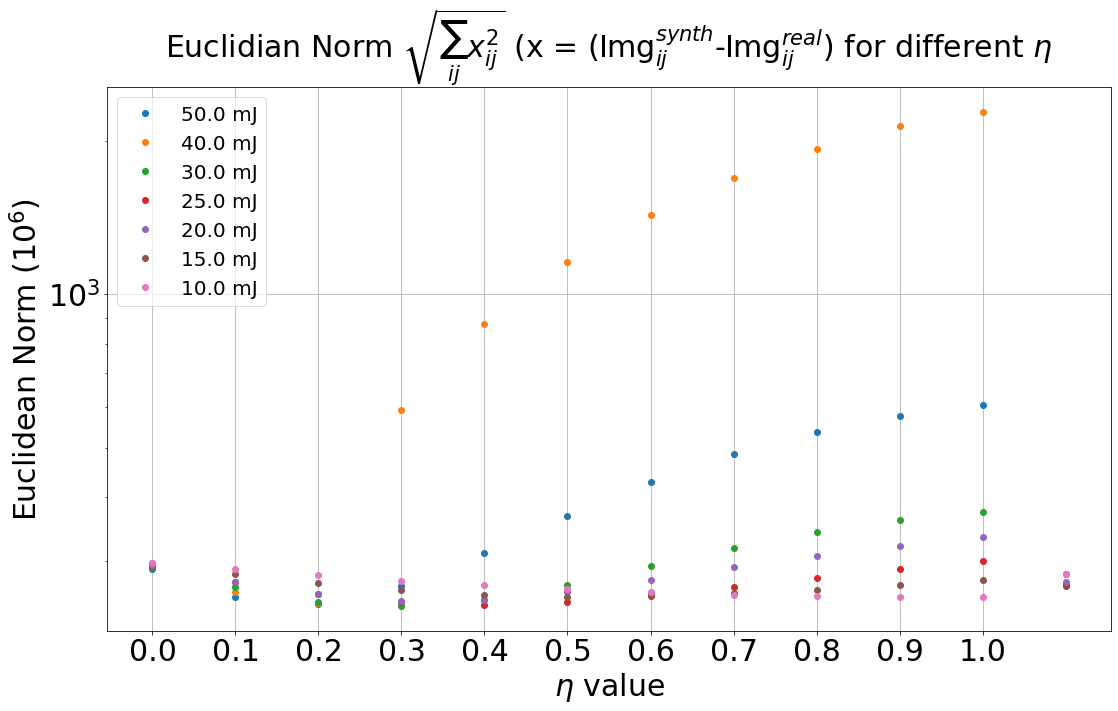

In [1159]:
energies = energies_10080

super_diff = []
plt.figure(figsize = (18,10))
for i,img_ in enumerate(avgd_images_10080):
    
    bound = 150
    
    cent = int(len(img_)/2)
    
    img = img_ - np.min(img_)
    img = img[cent-bound:cent+bound+1:,cent-bound:cent+bound+1]#/np.max(img)
    difference = []
    k = synths_real_10080[0][i]
    k_normed = k[0] - np.min(k[0])
    print(np.min(k[0]))
    k_normed = k_normed[cent-bound:cent+bound+1:,cent-bound:cent+bound+1]#/np.max(img)
    diff = np.sqrt(np.sum(np.divide(np.power(np.add(k_normed,-img),2),img**2+1)))
    #print(diff)
    difference.append(diff)
    for k in range(0,len(global_interpolated_10080)):
        sy_img = global_interpolated_10080[k][0][i][0]
        sy_img = sy_img[cent-bound:cent+bound+1:,cent-bound:cent+bound+1]#/np.max(img)
        sy_img += -np.min(sy_img)
        #img += -np.min(img)
        #plt.plot(global_reals[2][1][0][0][6])
        #plt.show()
        #plt.imshow(global_reals[2][0][0][0])

        diff = np.sqrt(np.sum(np.divide(np.power(np.add(sy_img,-img),2),img**2+1)))
        super_diff.append(difference)
        difference.append(round(diff,2))
    

    
    x = [1.1]
    x += [k for k in fraction_vals]
    #x.append(1.1)
    plt.semilogy(x,difference,'o',label =  '%.1f mJ'%energies[i])

plt.legend(loc = 'upper left',framealpha = 0.7,fontsize = 20)
#plt.ylim(0.5e6,4e6)

plt.xticks(fraction_vals,fontsize = 30)
plt.xlabel(r'$\eta$ value',fontsize  = 30)

plt.yticks(fontsize = 30)
plt.ylabel(r'Euclidean Norm ($10^{6}$)',fontsize = 30)

plt.title(r'Euclidian Norm $\sqrt{\sum_{ij}{x_{ij}^{2}}}$ (x = (Img$_{ij}^{synth}$-Img$_{ij}^{real}$) for different $\eta$',fontsize = 30)
plt.grid(True,which='major', axis='both')

#plt.plot([1.1 for k in range(len(synths_real[0]))],differences_freevar,'o')
plt.show()

# Define functions to fit each parameters

#### Offsets


#### Heights


#### Sigmas


#### Mus


#### Alphas

In [122]:
#Offsets 
def exp_bucket_offsets(x,xshifter
                        ,yshifter
                        ,scaler
                        ,w):
    
    xn = x + xshifter
    return yshifter + scaler*(np.exp(-w*xn) + np.exp(w*xn))

#Heights
def quadratic_height_sig(x,a,b,c):
    return a*x**2 +b*x + c

#Mus
def sigmoid_mu(x,xshifter
                ,yshifter
                ,slopeshifter
                ,scaler):
    c = scaler
    xn = x + xshifter
    yn = yshifter
    
    sigmoid_mu_pos = yn + slopeshifter*xn + c*1 /(1 + np.exp(-1.5*xn))
    return -sigmoid_mu_pos

mu_guess = [-90,-5,0.1,15]

#Alphas
def linear_alpha(x,a,b):
    return a*x + b

def null(x):
    return x

def mean_offset(x):
    mean_x = np.mean(x)
    ones = np.ones(len(x))
    
    return mean_x*ones

In [121]:
def linear(x,a,b):
    return a*x + b

def poly(x,y,polyrange):

    polyft = np.polyfit(x,y,polyrange)

    polynom = 0 
    polymax = len(polyft)-1
    for i in range(polymax+1):
        power = polymax-i
        polynom += polyft[i]*x**power

    return polynom,polyft

In [ ]:
titles = ['Offsets','Heights','Sigmas','Mus','Alphas']
functions = [exp_bucket_offsets,quadratic_height_sig,quadratic_height_sig,sigmoid_mu,linear_alpha]


def parameter_fit_interpolator(params_
                              ,fitting_functions   #MUST BE ORDERED
                              ,xspace
                              ,xfitspace):

    
    interped_fit_params = []
    opts = []
    covs = []
    jx = np.arange(0,181,1)
    jx2 = np.arange(0,180.1,0.1)
    for ip,param in enumerate(params_):
        param_cut = param[:181]
        #plt.plot(param_cut)

        #Offsets
        if ip == 0:
            bucket_guess = [-90,min(param_cut),15,0.05]
            #param = fitting_functions[ip](param_cut)
             
            bopt,bcov = curve_fit(fitting_functions[ip],jx,param_cut,p0 = bucket_guess,maxfev = 10000)
            opts.append(bopt)
            covs.append(bcov)
            func_fit = functions[ip](jx,*bopt)
            #plt.plot(jx,poly_fit[0])
            #plt.plot(jx,param_cut)
            #plt.plot(jx,func_fit)
            #plt.title(titles[ip])


            interped_param = interp1d(jx,func_fit ,kind = 'cubic')
            interped_fit_params.append(interped_param(jx2))

            #plt.show()
        #Heights
        if ip == 1:
            print(len(param_cut))
            poly_fit = poly(jx,param_cut,2)
            poly_guess = poly_fit[1]
            hopt,hcov = curve_fit(fitting_functions[ip],jx,param_cut,p0 = poly_guess)
            opts.append(hopt)
            covs.append(hcov)
            func_fit = functions[ip](jx,*hopt)
            #plt.plot(jx,poly_fit[0])
            #plt.plot(jx,param_cut)
            #plt.plot(jx,func_fit)
            #plt.title(titles[ip])

            interped_param = interp1d(jx,func_fit ,kind = 'cubic')
            interped_fit_params.append(interped_param(jx2))
            #plt.show()

        if ip == 2:
            poly_fit = poly(jx,param_cut,2)
            poly_guess = poly_fit[1]
            sopt,scov = curve_fit(fitting_functions[ip],jx,param_cut,p0 = poly_guess)
            opts.append(sopt)
            covs.append(scov)
            func_fit = functions[ip](jx,*sopt)
            #plt.plot(jx,param_cut)
            #plt.plot(jx,func_fit)
            #plt.title(titles[ip])

            interped_param = interp1d(jx,func_fit ,kind = 'cubic')
            interped_fit_params.append(interped_param(jx2))
            #plt.show()

        if ip == 3:
            sigmoid_guess = [-90,-5,0.1,15]
            mopt,mcov = curve_fit(fitting_functions[ip],jx,param_cut,p0 = sigmoid_guess)
            opts.append(mopt)
            covs.append(mcov)
            func_fit = functions[ip](jx,*mopt)
            #plt.plot(jx,param_cut)
            #plt.plot(jx,func_fit)
            #plt.title(titles[ip])

            interped_param = interp1d(jx,func_fit ,kind = 'cubic')
            interped_fit_params.append(interped_param(jx2))
            #plt.show()

        if ip == 4:
            poly_fit = poly(jx,param_cut,1)
            poly_guess = poly_fit[1]
            lopt,lcov = curve_fit(fitting_functions[ip],jx,param_cut)
            opts.append(lopt)
            covs.append(lcov)
            func_fit = functions[ip](jx,*lopt)
            #plt.plot(jx,param_cut)
            #plt.plot(jx,func_fit)
            #plt.title(titles[ip])

            interped_param = interp1d(jx,func_fit ,kind = 'cubic')
            interped_fit_params.append(interped_param(jx2))
            #plt.show()
    return interped_fit_params, opts,covs


In [ ]:
c=0
ti = 0

image_params = []
globopts = []
globcovs = []
sg_interp_fits = []

xnew = np.arange(0,180.1,0.1)

for k,kval in enumerate(synths_real[1]):
    image_params1 = []
    cent = int(len(kval)/2)
    trueimg = synths_real[0][k][0]
    param0 = synths_real[1][k][0][0]
    param1 = synths_real[1][k][0][1]
    param2 = synths_real[1][k][0][2]
    param3 = synths_real[1][k][0][3]
    param4 = synths_real[1][k][0][4]
    p



    params = [param0,param1,param2,param3,param4]

    fit_params = parameter_fit_interpolator(params
                                              ,functions   #MUST BE ORDERED
                                              ,[]
                                              ,[])
    fitint_params = fit_params[0]


    globopts.append(fit_params[1])
    globcovs.append(fit_params[2])


    xarr = np.zeros([trueimg.shape[0],trueimg.shape[1]],dtype = int)
    for i in range(len(xarr)):
        for j in range(len(xarr)):
            xarr[i,j] = i

    cent = int(len(xarr[0])/2)
    xmat = np.add(np.matrix(xarr),-cent)
    ymat = np.add(np.matrix(xarr).T,-cent)

    arctan_mat = np.round(np.round(np.arctan2(ymat,xmat),2)*180/np.pi,5)
    arctan_mat = np.add(arctan_mat,180)
    arctan_mat = np.flip(np.flip(arctan_mat.T,axis = 1),axis = 0)
    arctan_mat[:cent+1:,]+=-180

    arctan_arr = np.array(np.ndarray.flatten(arctan_mat))
    arctan_unarr = np.unique(arctan_arr)

    distmat = np.round(np.sqrt(np.add(np.power(xmat,2),np.power(ymat,2))),4)

    #plt.plot(xnew[:1800],line)
    #plt.plot(xnew[1800:],line2)
    #plt.plot(xnew,fin(xnew))
    #plt.ylim(-8,8)
    #plt.xlim(0,361)
    #plt.show()

    dict0 = dict(zip(xnew[:1801],fitint_params[0]))
    dict1 = dict(zip(xnew[:1801],fitint_params[1]))
    dict2 = dict(zip(xnew[:1801],fitint_params[2]))
    dict3 = dict(zip(xnew[:1801],fitint_params[3]))
    dict4 = dict(zip(xnew[:1801],fitint_params[4]))
    dict5 = dict(zip(xnew[:1801],fitint_params[5]))
    dict6 = dict(zip(xnew[:1801],fitint_params[6]))

    arcmat_map0 = np.vectorize(dict0.get)(np.round(arctan_mat),1)
    arcmat_map1 = np.vectorize(dict1.get)(np.round(arctan_mat),1)
    arcmat_map2 = np.vectorize(dict2.get)(np.round(arctan_mat),1)
    arcmat_map3 = np.vectorize(dict3.get)(np.round(arctan_mat),1)
    arcmat_map4 = np.vectorize(dict4.get)(np.round(arctan_mat),1)
    arcmat_map5 = np.vectorize(dict5.get)(np.round(arctan_mat),1)
    arcmat_map6 = np.vectorize(dict6.get)(np.round(arctan_mat),1)

    distmat[:cent+1:,]*= -1

    sg_fitint = Skewed_Pseudo_Voigt_synthetic_plasma(distmat,arctan_mat
                                             ,arcmat_map0,arcmat_map1
                                             ,arcmat_map2,arcmat_map3,arcmat_map4
                                             ,arcmat_map5,arcmat_map6)

    squim = square_image_cropper()
    
    fig0,axs0 = plt.subplots(1,3,figsize = (12,8))
    fig1,axs1 = plt.subplots(1,5,figsize = (15,4))
    axs0[0].imshow(avgd_images[k])
    axs0[1].imshow(synths_real[0][k][0])
    axs0[2].imshow(sg_fitint)



    jx = np.arange(0,361,1)
    for ik,k in enumerate(fitint_params):
        axs1[ik].plot(jx[:181],params[ik][:181])
        axs1[ik].plot(xnew[:1801],k)
        axs1[ik].set_title(titles[ik],fontsize = 25)
        axs1[ik].set_xlabel('Angle',fontsize = 20)
        axs1[ik].set_ylabel('Param Value',fontsize = 20)
    fig1.tight_layout()
    plt.show()
    print('----------')
    print('----------')
    print('----------')
    
    
    sg_interp_fits.append(sg_fitint)
        

In [ ]:
plt.imshow(synths_real[0][3][0])

In [ ]:
val.shape

In [ ]:
synths_with_interpolationskewed_diff_fit = []
gauss_diff_fit = []

skewed_diff_interp = []
gauss_diff_interp = []

skewed_diff_param = []
gauss_diff_param = []

interped_image_diff = []
fitted_image_diff = []
param_image_diff = []

for i,val_ in enumerate(images[0:5]):
    squim = square_image_cropper(val_,0.45)
    squim_cent = int(len(squim)/2)
    
    squim = squim[squim_cent-200:squim_cent+201:,squim_cent-200:squim_cent+201]
    
    
    val = squim - np.min(squim)
    fig,axs = plt.subplots(1,4,figsize = (21,4))
    fig.suptitle('Energy = %i mJ'%energies[i],fontsize = 20, y = 1.15)
    
    
    synth_fit_ = sg_interp_fits[i]
    cent_fit = int(len(synth_fit_)/2)
    synth_fit = synth_fit_[cent_fit-200:cent_fit+201:,cent_fit-200:cent_fit+201]

    
    
    synth_interp_ = synths_real[0][i][0][cent-200:cent+201:,cent-200:cent+201]
    cent = int(len(synths_real[0][i][0])/2)
    synth_interp = synth_interp_ - np.min(synth_interp_)
    

    
    synth_param_ = synths_no_interpolation[0][i][0]
    cent_param = int(len(synth_param_)/2)
    synth_param = synth_param_[cent_param-200:cent_param+201:,cent_param-200:cent_param+201]
    
    

    axs[0].imshow(val)
    axs[0].set_title('Real Plasma (4 Averaged)',fontsize = 16)
    axs[1].imshow(synth_interp)
    axs[1].set_title('Simulated',fontsize = 16)
    
    inf = 1
    sup = inf + 1
    
    val_strip0 = val[int(val.shape[0]/2)-inf:int(val.shape[0]/2)+sup]
    print(val_strip0.shape)
    val_strip1 = val[:,int(val.shape[0]/2)-inf:int(val.shape[0]/2)+sup]
    synth_interp_strip0 = synth_interp[int(synth_interp.shape[0]/2)-inf:int(synth_interp.shape[0]/2)+sup]
    synth_interp_strip1 = synth_interp[:,int(synth_interp.shape[0]/2)-inf:int(synth_interp.shape[0]/2)+sup]
    
    
    axs[2].plot(np.mean(val_strip1,axis = 1)-np.min(np.mean(val_strip1,axis = 1)),label = 'Real')
    axs[2].plot(np.mean(synth_interp_strip1,axis = 1)-np.min(np.mean(synth_interp_strip1,axis = 1)), label = 'Synthetic')
    axs[2].set_title('Gauss (Avg. cols)',  fontsize = 16)
   
    axs[3].plot(np.mean(val_strip0,axis = 0)-np.min(np.mean(val_strip0,axis=0)))
    axs[3].plot(np.mean(synth_interp_strip0,axis = 0)-np.min(np.mean(synth_interp_strip0,axis=0)))
    axs[3].set_title('Skew Gauss (Avg. rows)',  fontsize = 16)
    
    #axs[2].legend(loc = 'upper left',fontsize = 16, framealpha = 0.3)
    plt.show()
    
    print('True image',val.shape)
    print('Fitted im',synth_fit.shape)
    print('Interp im',synth_interp.shape)
    
    skewed_diff_fit.append(np.sqrt(np.sum(np.power(np.mean(val,axis = 1) - np.mean(synth_fit,axis = 1),2))))
    gauss_diff_fit.append(np.sqrt(np.sum(np.power(np.mean(val,axis = 0) - np.mean(synth_fit,axis = 0),2))))

    skewed_diff_interp.append(np.sqrt(np.sum(np.power(np.mean(val,axis = 1) - np.mean(synth_interp,axis = 1),2))))
    gauss_diff_interp.append(np.sqrt(np.sum(np.power(np.mean(val,axis = 0) - np.mean(synth_interp,axis = 0),2))))
    
    skewed_diff_param.append(np.sqrt(np.sum(np.power(np.mean(val,axis = 1) - np.mean(synth_param,axis = 1),2))))
    gauss_diff_param.append(np.sqrt(np.sum(np.power(np.mean(val,axis = 0) - np.mean(synth_param,axis = 0),2))))
    

    interped_diff = np.sqrt(np.sum(np.power(val-synth_interp,2)))
    fitted_diff = np.sqrt(np.sum(np.power(val-synth_fit,2)))
    param_diff = np.sqrt(np.sum(np.power(val-synth_param,2)))
    interped_image_diff.append(np.sum(np.power(val-interped_diff,2)))
    fitted_image_diff.append(np.sum(np.power(val-fitted_diff,2)))
    param_image_diff.append(np.sum(np.power(val-param_diff,2)))

In [ ]:
plt.title('Skewed Gaussian Euclidean Difference', fontsize = 15)
plt.plot(energies,skewed_diff_interp,'o',ls ='--', label = 'Real vs. Interpolation & Filter')
plt.plot(energies,skewed_diff_fit,'o',ls ='--', label = 'Real vs. Interpolation & Fitted')
plt.plot(energies,skewed_diff_param,'o',ls ='--', label = 'Real vs. Parameters')
#plt.plot(energies,np.array(skewed_diff2)-np.array(skewed_diff),'.', label = 'Diff. between pts.')
plt.ylim(0,)

plt.xlabel('Laser Energy (Attenuated)', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Euclidean Norm',fontsize = 15)
plt.yticks(fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.show()



plt.title('Gaussian Euclidean Difference', fontsize = 15)
plt.plot(energies,gauss_diff_interp,'o',ls ='--', label = 'Real vs. Interpolation & Filter')
plt.plot(energies,gauss_diff_fit,'o',ls ='--', label = 'Real vs. Interpolation & Fitted')
plt.plot(energies,gauss_diff_param,'o',ls ='--', label = 'Real vs. Parameters')
#plt.plot(energies,np.array(gauss_diff2)-np.array(gauss_diff),'.', label = 'Diff. between pts.')
plt.ylim(0,)

plt.xlabel('Laser Energy (Attenuated)', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Euclidean Norm',fontsize = 15)
plt.yticks(fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

plt.title('Euclidean Difference - Real vs Simulated image', fontsize = 15)
plt.plot(energies,interped_image_diff,'o',ls = '--',label = 'Real vs. Interpolation & Filter')
plt.plot(energies,fitted_image_diff,'o',ls = '--',label = 'Real vs. Interpolation & Fitted')
plt.plot(energies,param_image_diff,'o',ls = '--',label = 'Real vs. Parameters')
#plt.plot(energies,np.array(fitted_image_diff)-np.array(interped_image_diff),'.', label = 'Diff. between pts.')
plt.legend(loc = 'upper left', fontsize = 12)
plt.ylim(0,)

plt.xlabel('Laser Energy (Attenuated)', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Euclidean Norm',fontsize = 15)
plt.yticks(fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 12, framealpha = 0.35)
plt.show()

In [ ]:
for i in range(0,len(globopts)):
    plt.plot(energies[i],globopts[i][2][0],'o', color = 'tab:orange')
    plt.xlabel('Laser Energy (Attenuated)',fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.ylabel('Value of coefficient',fontsize = 15)
    plt.yticks(fontsize = 12)
    plt.title('Skewness Slope',fontsize = 15)
    
plt.show()
for i in range(0,len(globopts)):
    plt.plot(energies[i],globopts[i][2][2],'o', color = 'tab:orange')
    plt.xlabel('Laser Energy (Attenuated)',fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.ylabel('Value of coefficient',fontsize = 15)
    plt.yticks(fontsize = 12)
    plt.title('Sigmas Intercept',fontsize = 15)

In [ ]:
real_fwhm_list = []
filt_fwhm_list = []
fitt_fwhm_list = []
param_fwhm_list = []

for i,val in enumerate(avgd_images):
    synth_fit = sg_interp_fits[i]
    synth_interp = synths_real[0][i][0]
    synth_param = synths_no_interpolation[0][i][0]
    if i == 0:
        x_orig = np.arange(0,len(val),1)
        x_long = np.arange(0,len(val)-0.95,0.05)
    

    filt_fwhm = exper_FWHM( interp1d(x_orig,np.mean(synth_interp,axis = 1),kind = 'cubic')(x_long))
    fitt_fwhm = exper_FWHM( interp1d(x_orig,np.mean(synth_fit,axis = 1),kind = 'cubic')(x_long))
    param_fwhm = exper_FWHM( interp1d(x_orig,np.mean(synth_param,axis = 1),kind = 'cubic')(x_long))
    real_fwhm = exper_FWHM( interp1d(x_orig,np.mean(val,axis = 1),kind = 'cubic')(x_long))
    
    print(real_fwhm[1]-real_fwhm[0])
    
    real_fwhm_list.append(x_long[real_fwhm[1]]-x_long[real_fwhm[0]])
    filt_fwhm_list.append(x_long[filt_fwhm[1]]-x_long[filt_fwhm[0]])
    fitt_fwhm_list.append(x_long[fitt_fwhm[1]]-x_long[fitt_fwhm[0]])
    param_fwhm_list.append(x_long[param_fwhm[1]]-x_long[param_fwhm[0]])
    
plt.plot(energies, real_fwhm_list,'o',ls = '--', label = 'Real FWHM')
plt.plot(energies, filt_fwhm_list,'o',ls = '--', label = 'Filtered FWHM')
plt.plot(energies, fitt_fwhm_list,'o',ls = '--', label = 'Fitted FWHM')
plt.plot(energies, param_fwhm_list,'o',ls = '--', label = 'Parameter FWHM')

plt.legend(loc = 'best')

plt.xlabel('Energy',fontsize = 15)
plt.xticks(fontsize = 13)
plt.ylabel('FWHM', fontsize = 15)
plt.yticks(fontsize = 13)
plt.title('Comparing FWHM of different cross sections', fontsize = 15)
plt.show()

In [ ]:
def image_summer(image,degree_step):
    squim = square_image_cropper(image)
    
    deg_start = 0
    deg_step = degree_step
    deg_stop = 360
    angle_range = np.arange(deg_start,deg_stop,deg_step)
    
    alphas = np.zeros(len(angle_range))
    heights_normed = np.zeros(len(angle_range))
    sigmas = np.zeros(len(angle_range))
    mus = np.zeros(len(angle_range)) 
    
    for i,val in enumerate(angle_range):
        #print(i)
        img_rotated = ndimage.rotate(squim, val+1, reshape=False, cval = np.mean(image))


## Image normalisation: Comparing real and synthetic plasma images

To calculate the error on the below graph, we assume
- The graphs are cocentric i.e. pt [i,j] on the fit corresponds to pt [i,j] on the actual plasma image
- The images are equally sized

The equation used is the Euclidian norm 
\begin{equation}
perr = \sqrt{\sum_{i}{\big(p_{i}^{actual}-p_{i}^{fit}\big)}^{2}}
\end{equation}
where $p_{i}^{actual}$ is the __normalised__ ith element of the __flattened array__ of the real image matrix, and similarly $p_{i}^{fit}$ is the __normalised__ ith element of the __flattened array__ fitted image matrix. Both matrices are normalised with respect to themselves

In [ ]:
plt.figure(figsize = (20,10)) 
for j,k in enumerate(synths_real[0]):
    
    actual = square_image_cropper(images[j],0.45)
    actual_normed = actual/1#np.max(actual)
    
    differences = []
    for i,l in enumerate(k):
        
        l_normed = l/1#np.max(l)
        #plt.imshow(l_normed)
        #plt.show()
        diff = np.sqrt(np.nansum(np.power(np.ndarray.flatten(l_normed) - np.ndarray.flatten(actual_normed),2)))
        #print(diff)
        differences.append(diff)
   
    plt.title('5 images @ E = %s mJ' %ens[j],fontsize = 30)
    plt.xlabel('Strip Width', fontsize = 30)
    plt.xticks(fontsize = 30)

    plt.ylabel(r'Error $(\sqrt{\sum_{i}{(p_{i}^{actual}-p_{i}^{fit})}^{2}})$', fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.loglog(strip_widths,differences,'o', ls = '--')
    np.argmin(differences)
    plt.grid(True, which = 'both', ls = '-',lw = 2)
    #break
    
for j,k in enumerate(synths[0]):
    
    actual = square_image_cropper(images[j],0.45)
    actual_normed = actual/1#np.max(actual)
    
    differences = []
    for i,l in enumerate(k):
        
        l_normed = l/1#np.max(l)
        #plt.imshow(l_normed)
        #plt.show()
        diff = np.sqrt(np.nansum(np.power(np.ndarray.flatten(l_normed) - np.ndarray.flatten(actual_normed),2)))
        #print(diff)
        differences.append(diff)
   
    plt.title('5 images @ E = %s mJ' %ens[j],fontsize = 30)
    plt.xlabel('Strip Width', fontsize = 30)
    plt.xticks(fontsize = 30)

    plt.ylabel(r'Error $(\sqrt{\sum_{i}{(p_{i}^{actual}-p_{i}^{fit})}^{2}})$', fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.loglog(strip_widths,differences,'o', ls = '--')
    np.argmin(differences)
    plt.grid(True, which = 'both', ls = '-',lw = 2)
    #break

# Convert focus

This function defines the first focus as 0. After that, the 

In [ ]:
def focus_list_adjuster(focus_list):
    newfoc_list = []
    zero_focus = focus_list[0]
    onestep = 1
    for focus in focus_list:
        zerofoc = focus - zero_focus
        newfoc = zerofoc*onestep
        newfoc_list.append(newfoc)
    
    return newfoc_list 

focus_list_adjuster([10220,10240])